In [1]:
suppressPackageStartupMessages(library(MASS))
suppressPackageStartupMessages(library(nlme))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(mgcv))
suppressPackageStartupMessages(library(ggrepel))

In [2]:
data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"
mcc_file = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/otu_tables/microbial_community_clusters.txt"

env_data_file = paste(data_dir, "merged_paired_water_quality_data.txt", sep="/")
habitat_file = paste(data_dir, "Transformed_WQ_Vars_and_Habitats.txt", sep="/")


habitat_srs <- read.delim(habitat_file, row.names=1)
badhabits <- names(habitat_srs) %in% names(habitat_srs)[grep('HABITAT', colnames(habitat_srs))]
habitat_srs <- habitat_srs[!badhabits]
mcc_srs <- read.delim(mcc_file, row.names=1)[rownames(habitat_srs),c('Microbial.Clusters', 'Habitat')]
envdata_pre <- read.delim(env_data_file, row.names=1)
colnames(envdata_pre)
addl_cols = c('Station', "qPCR.ct", "WaterColumnPosition", "LinearTime", 'FallPeak', "DayLength",
              "cruise_id", 'SampleDate', 'Discharge_Sum.15' , 'Discharge_Susquehanna.15' )
envdata <- cbind.data.frame(habitat_srs, envdata_pre[rownames(habitat_srs), addl_cols],
                            mcc_srs)

envdata[which(envdata$qPCR.ct %in% c("", 'TBD')), 'qPCR.ct'] = NA
envdata[,'Habitat'] <- factor(envdata[,'Habitat'])
envdata[,'Station'] <- factor(envdata[,'Station'])
envdata[,'WaterColumnPosition'] <- factor(envdata[,'WaterColumnPosition'])
envdata[,'cruise_id'] <- factor(envdata[,'cruise_id'])
str(envdata)

[1] "Station"                        "OLD_DATE_TIME"                 
 [3] "OldDepth"                       "qPCR.ct"                       
 [5] "CollectionAgency"               "sequencing_ID"                 
 [7] "TrimCount"                      "TotalDepth"                    
 [9] "PctTotalDepth"                  "WaterColumnPosition"           
[11] "cruise_id"                      "SampleDate"                    
[13] "Depth"                          "PHEO"                          
[15] "TN"                             "TP"                            
[17] "CHLA"                           "DOP"                           
[19] "DON"                            "NH4F"                          
[21] "NO2F"                           "NO3F"                          
[23] "PC"                             "PO4F"                          
[25] "DO"                             "PH"                            
[27] "SALINITY"                       "WTEMP"                         
[29] "LinearTime"                     "DayLength"                     
[31] "FallPeak"                       "SpringPeak"                    
[33] "Discharge_Rappahannock.instant" "Discharge_Rappahannock.15"     
[35] "Discharge_Rappahannock.30"      "Discharge_Rappahannock.60"     
[37] "Discharge_Potomac.instant"      "Discharge_Potomac.15"          
[39] "Discharge_Potomac.30"           "Discharge_Potomac.60"          
[41] "Discharge_Susquehanna.instant"  "Discharge_Susquehanna.15"      
[43] "Discharge_Susquehanna.30"       "Discharge_Susquehanna.60"      
[45] "interpolated_CHLA.instant"      "interpolated_CHLA.15"          
[47] "interpolated_CHLA.30"           "interpolated_CHLA.60"          
[49] "measurement_PAR.instant"        "measurement_PAR.15"            
[51] "measurement_PAR.30"             "measurement_PAR.60"            
[53] "WIND_RATIO_BWI.instant"         "WIND_RATIO_BWI.15"             
[55] "WIND_RATIO_BWI.30"              "WIND_RATIO_BWI.60"             
[57] "PRECIP24HR_BWI.instant"         "PRECIP24HR_BWI.15"             
[59] "PRECIP24HR_BWI.30"              "PRECIP24HR_BWI.60"             
[61] "Discharge_Sum.instant"          "Discharge_Sum.15"              
[63] "Discharge_Sum.30"               "Discharge_Sum.60"              
[65] "Latitude"                       "Longitude"

'data.frame':	236 obs. of  28 variables:
 $ PHEO                    : num  1.223 0.125 0.125 0.414 0.125 ...
 $ TN                      : num  0.889 -3.102 -1.186 -1.044 -0.691 ...
 $ TP                      : num  -0.165 -1.63 -0.873 -0.102 -0.65 ...
 $ CHLA                    : num  0.968 -0.862 0.348 -0.677 -0.272 ...
 $ DOP                     : num  -0.629 0.24 0.442 -2.48 0.509 ...
 $ DON                     : num  1.13 -2.78 -1.3 -1.64 -1.22 ...
 $ NH4F                    : num  -0.2277 -1.0574 -0.0443 0.419 0.6352 ...
 $ NO2F                    : num  0.266 -0.661 -0.148 -0.212 0.162 ...
 $ NO3F                    : num  0.786 -1.09 -0.342 -0.353 -0.341 ...
 $ PC                      : num  0.489 -2.065 -0.544 -0.333 -0.438 ...
 $ PO4F                    : num  -0.7433 0.0383 0.124 0.4004 0.2463 ...
 $ DO                      : num  0.1231 0.4676 -0.3698 0.0102 -0.3293 ...
 $ PH                      : num  -1.3745 0.3943 -0.0675 0.22 -0.085 ...
 $ SALINITY                : num 

In [3]:
station_groups = list('1' = c('CB2.2', 'CB3.1'),
                      '2' = c('CB3.2', 'CB3.3C', 'CB4.1C', 'CB4.2C'),
                      '3' = c('CB4.3C', 'CB4.4'),
                      '4' = c('CB5.1', 'CB5.2'),
                      '5' = c('CB5.4', 'CB5.3', 'CB7.1'),
                      '6' = c('CB6.2', 'CB6.1', 'CB6.3', 'CB6.4'),
                      '7' = c('CB7.2', 'CB7.3', 'CB7.4'))

envdata[,'StatName'] <- NA
for (stg in names(station_groups)){
    envdata[which(envdata[,'Station'] %in% station_groups[[stg]]), 'StatName'] <- stg
}

envdata$StatName <- factor(envdata$StatName)
print(sum(is.na(envdata[,'StatName'])))
table(envdata$StatName)


[1] 0



 1  2  3  4  5  6  7 
26 39 28 12 52 50 29 

In [30]:
library(phyloseq)
library(picante)
#OTU table rarefied only
otu_table_dir = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/otu_tables'
otu_table_file = paste(otu_table_dir, "final_rare_no_abund_filt.2.txt", sep="/")
OTU = read.delim(otu_table_file, row.names=1)
OTU.clean1 = OTU[rownames(envdata), ]
OTU.clean = as.matrix(OTU.clean1[,colSums(OTU.clean1) > 0])

sample(rowSums(OTU.clean), 10)
sample(colSums(OTU.clean), 10)

# OTU table rarefied abundance threshold
otu_table_file2 = paste(otu_table_dir, "final_rarefied_table.2.txt", sep="/")
OTU.rar.thresh = read.delim(otu_table_file2, row.names=1)
OTU.clean.rar.thresh = OTU.rar.thresh[rownames(envdata), ]
OTU.clean.rar.thresh = as.matrix(OTU.rar.thresh[,colSums(OTU.rar.thresh) > 0])

sample(rowSums(OTU.clean.rar.thresh), 10)
sample(colSums(OTU.clean.rar.thresh), 10)

# OTU Table raw
otu_table_file3 = paste(otu_table_dir, "final_unrarefied_table.2.txt", sep="/")
OTU.clean.raw = read.delim(otu_table_file3, row.names=1)
OTU.clean.raw = OTU.clean.raw[rownames(envdata), ]
OTU.clean.raw = as.matrix(OTU.clean.raw[,colSums(OTU.clean.raw) > 0])

sample(rowSums(OTU.clean.raw), 10)
sample(colSums(OTU.clean.raw), 10)

SB071116TAWCSCB63D10BR1TR1I163 SB080717TAWCSCB42CD26BR1TR1I429 
                           3125                            3125 
 SB091817TAWCSCB32D10BR1TR1I494  SB050817TAWCSCB73D12BR1TR1I342 
                           3125                            3125 
 SB071116TAWCSCB71D20BR2TR1I168  SB071116TAWCSCB54D25BR1TR1I157 
                           3125                            3125 
 SB071017TAWCSCB61D11BR1TR1I404  SB082916TAWCSCB44D30BR1TR1I222 
                           3125                            3125 
 SB080717TAWCSCB71D20BR1TR1I451  SB081216TAWCSCB54D25BR2TR1I191 
                           3125                            3125

OTU7434 OTU13860  OTU6616 OTU12818  OTU7464  OTU7077 OTU11631  OTU6060 
       2        3        4        1        1        4        3        7 
OTU14346  OTU4401 
       2       12

SB060517TAWCSCB63D10BR1TR1I381 SB060517TAWCSCB54D25BR1TR1I377 
                          2997                           2997 
SB081216TAWCSCB32D10BR1TR1I180  SB071116TAWCSCB62D9BR1TR1I161 
                          2997                           2997 
SB071316TAWCSCB22D11BR2TR2I613 SB091817TAWCSCB63D10BR1TR1I508 
                          2997                           2997 
SB050817TAWCSCB54D25BR1TR1I334  SB050817TAWCSCB62D9BR1TR1I337 
                          2997                           2997 
SB080717TAWCSCB73D12BR1TR1I444 SB080717TAWCSCB71D20BR1TR1I451 
                          2997                           2997

OTU287 OTU1856   OTU70  OTU239  OTU919  OTU365  OTU773 OTU2272  OTU398  OTU378 
    202      90    2872     318     123     278     164      36     253     467

SB060517TAWCSCB61D11BR1TR1I370 SB060517TAWCSCB33CD24BR1TR1I359 
                         129028                          105456 
 SB081216TAWCSCB63D11BR2TR1I196   SB071116TAWCSCB62D9BR1TR1I161 
                         219595                            6129 
 SB080717TAWCSCB63D10BR1TR1I440  SB071116TAWCSCB22D11BR2TR2I616 
                          36941                          141237 
 SB041117TAWCSCB54D25BR2TR1I310   SB041117TAWCSCB62D9BR1TR1I303 
                          80298                           36753 
 SB082916TAWCSCB64D10BR2TR1I237  SB081216TAWCSCB22D11BR1TR2I617 
                           9466                          201531

OTU28218 OTU47545 OTU30516 OTU45710  OTU4494 OTU13906 OTU52659 OTU53886 
      13        4       11        4      442       47        2        2 
OTU44662 OTU37309 
       4        7

In [31]:
#Taxonomy of each OTU
taxa_file = paste(otu_table_dir, "taxa_table_with_OTUs.txt", sep="/")
tax = read.delim(taxa_file, row.names=1)
tax_mat = as.matrix(tax)
colnames(tax_mat)[1] <- 'Domain'
tax_mat[tax_mat == ""] <- NA

tax.table.clean.raw  = tax_mat[colnames(OTU.clean.raw), ]
OTU.table.clean.raw = otu_table(OTU.clean.raw, taxa_are_rows = FALSE)
TAX.table.clean.raw = tax_table(tax.table.clean.raw)
physeq.clean.raw = phyloseq(OTU.table.clean.raw, TAX.table.clean.raw)
physeq.clean.raw

tax.table.clean.rar.t  = tax_mat[colnames(OTU.clean.rar.thresh), ]
OTU.table.clean.rar.t = otu_table(OTU.clean.rar.thresh, taxa_are_rows = FALSE)
TAX.table.clean.rar.t = tax_table(tax.table.clean.rar.t)
physeq.clean.rar.t = phyloseq(OTU.table.clean.rar.t, TAX.table.clean.rar.t)
physeq.clean.rar.t

tax.table.clean  = tax_mat[colnames(OTU.clean), ]
OTU.table.clean = otu_table(OTU.clean, taxa_are_rows = FALSE)
TAX.table.clean = tax_table(tax.table.clean)
physeq.clean = phyloseq(OTU.table.clean, TAX.table.clean)
physeq.clean

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 27746 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 27746 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1416 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 1416 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11450 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 11450 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 27746 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 27746 taxa by 7 taxonomic ranks ]

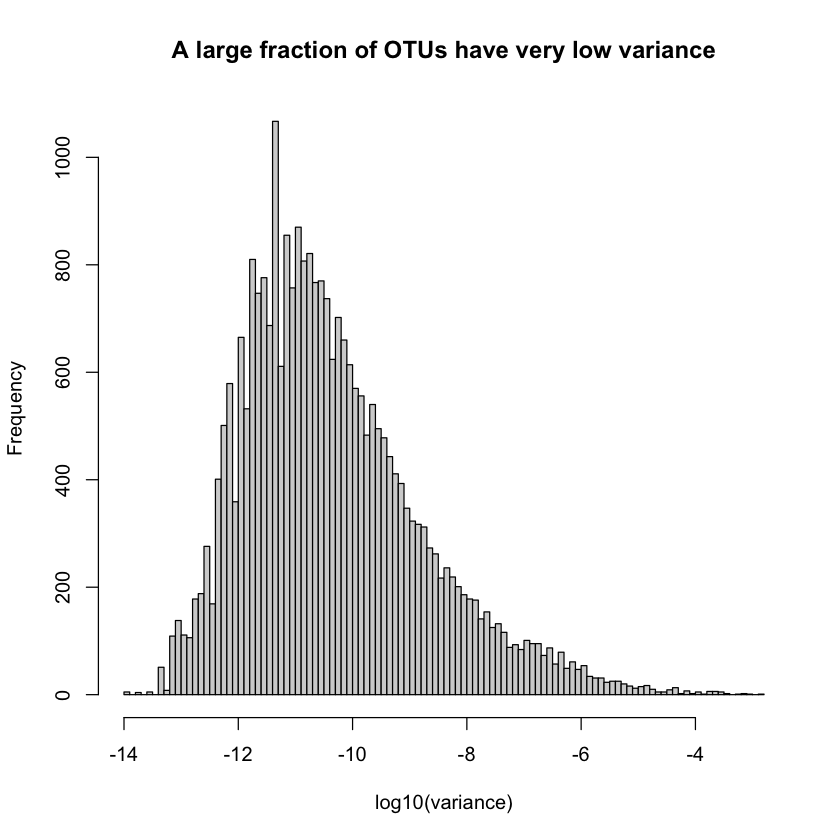

In [21]:
physeq.clean.raw.ra = transform_sample_counts(physeq.clean.raw, function(x){x/sum(x)})
logvar = log10(apply(otu_table(physeq.clean.raw.ra), 2, var))
hist(logvar, xlab="log10(variance)", breaks=100, main="A large fraction of OTUs have very low variance")

diff_Thresholds = list()
counter=0
for (varianceThreshold in 10^(-1*seq(5, 9, 0.25))){
    keepOTUs = names(which(apply(otu_table(physeq.clean.raw.ra), 2, var) > varianceThreshold))
    physeq.clean.vt = prune_taxa(keepOTUs, physeq.clean.raw.ra)
    physeq.clean.vt
    counter=counter + 1
    diff_Thresholds[[counter]] = physeq.clean.vt
    flush.console()
}

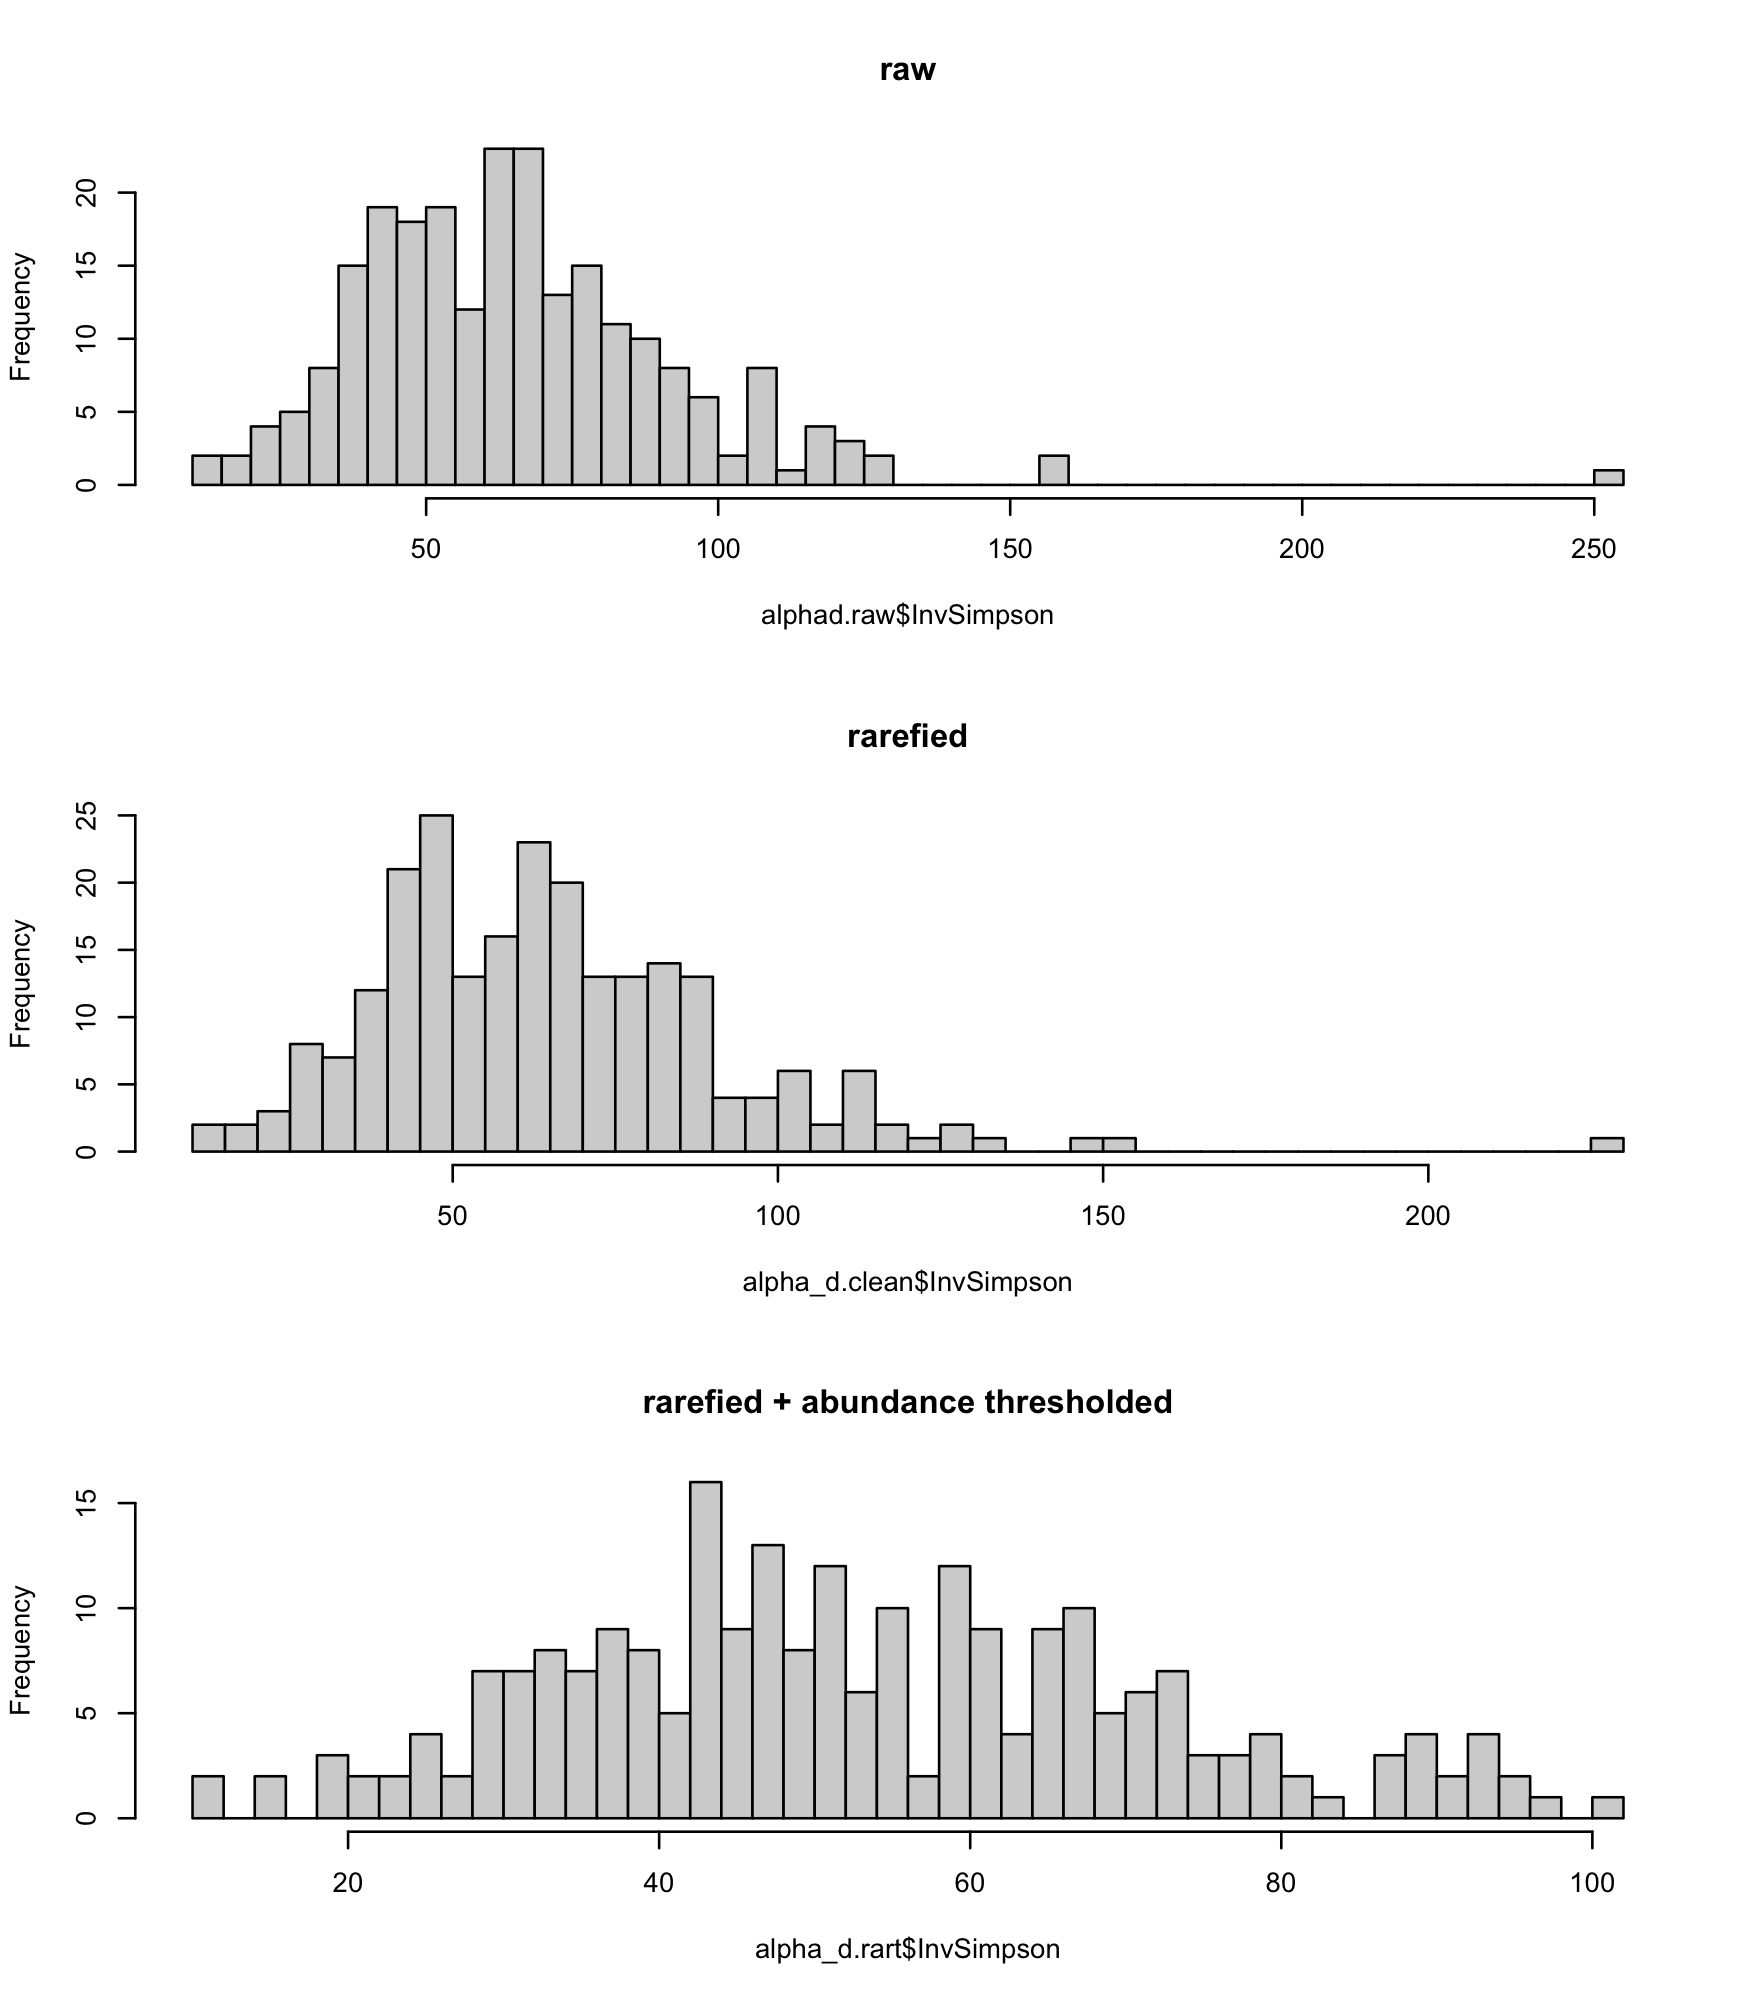

In [28]:
alphad.raw = estimate_richness(physeq.clean.raw, split = TRUE, measures = c('InvSimpson'))
alpha_d.rart = estimate_richness(physeq.clean.rar.t, split = TRUE, measures = c('InvSimpson'))
alpha_d.clean = estimate_richness(physeq.clean, split = TRUE, measures = c('InvSimpson'))
options(repr.plot.width=7, repr.plot.height=8, repr.plot.res=250)
par(mfrow=c(3,1))
hist(alphad.raw$InvSimpson, breaks=50, main='raw')
hist(alpha_d.clean$InvSimpson, breaks=50, main='rarefied')
hist(alpha_d.rart$InvSimpson, breaks=50, main='rarefied + abundance thresholded')

In [29]:
threshs_used = 10^(-1*seq(5, 9, 0.25))
ra_table = otu_table(physeq.clean.raw.ra)
for (t in 1:length(diff_Thresholds)){
    physeq.clean.vt = diff_Thresholds[[t]]
    kept_babies = otu_table(physeq.clean.vt)
    minabund = min(apply(ra_table[,colnames(kept_babies)], 2, max))
    print(paste(t, threshs_used[t], round(minabund, 5), sep=" | "))
    alpha_d.x = estimate_richness(physeq.clean.vt, split = TRUE, measures = c('InvSimpson'))
    print(paste(round(quantile(alpha_d.x$InvSimpson, c(0.01, 0.25, 0.5, 0.75, .99)), 2), collapse=", "))
}

[1] "1 | 1e-05 | 0.01364"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "5.02, 16.74, 21.58, 26.48, 34.07"
[1] "2 | 5.62341325190349e-06 | 0.0108"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "6, 19.82, 25.54, 30.32, 39.1"
[1] "3 | 3.16227766016838e-06 | 0.00758"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "7.65, 23.11, 28.98, 36.05, 47.01"
[1] "4 | 1.77827941003892e-06 | 0.0059"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "8.47, 25.71, 32.75, 40.7, 54.03"
[1] "5 | 1e-06 | 0.00459"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "9.92, 29.14, 36.6, 46.7, 62.9"
[1] "6 | 5.62341325190349e-07 | 0.00359"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "11.17, 32.05, 40.77, 51.81, 71.67"
[1] "7 | 3.16227766016838e-07 | 0.00281"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "12, 34.46, 44.43, 55.91, 79.32"
[1] "8 | 1.77827941003892e-07 | 0.00188"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "13.05, 37.01, 47.57, 61.09, 84.67"
[1] "9 | 1e-07 | 0.00158"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "13.61, 38.8, 50.51, 65.63, 93.52"
[1] "10 | 5.62341325190349e-08 | 0.00121"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "13.97, 40.17, 53.01, 67.77, 97.54"
[1] "11 | 3.16227766016838e-08 | 0.00088"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "14.36, 41.04, 54.8, 70.22, 101.74"
[1] "12 | 1.77827941003892e-08 | 0.00067"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "14.71, 41.8, 56.01, 72.38, 108.28"
[1] "13 | 1e-08 | 0.00053"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "15, 42.84, 56.99, 74.42, 117.05"
[1] "14 | 5.62341325190349e-09 | 4e-04"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "15.27, 44.16, 57.83, 76.04, 121.3"
[1] "15 | 3.16227766016838e-09 | 0.00028"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "15.51, 44.58, 59.02, 77.06, 126.33"
[1] "16 | 1.77827941003892e-09 | 0.00023"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "15.7, 44.89, 59.52, 77.86, 131.61"
[1] "17 | 1e-09 | 0.00018"


Warning message in estimate_richness(physeq.clean.vt, split = TRUE, measures = c("InvSimpson")):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


[1] "15.85, 45.26, 60.7, 78.19, 135.53"


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11450 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 11450 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11450 tips and 11449 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1416 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 1416 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1416 tips and 1415 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1416 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 1416 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1416 tips and 1415 internal nodes ]

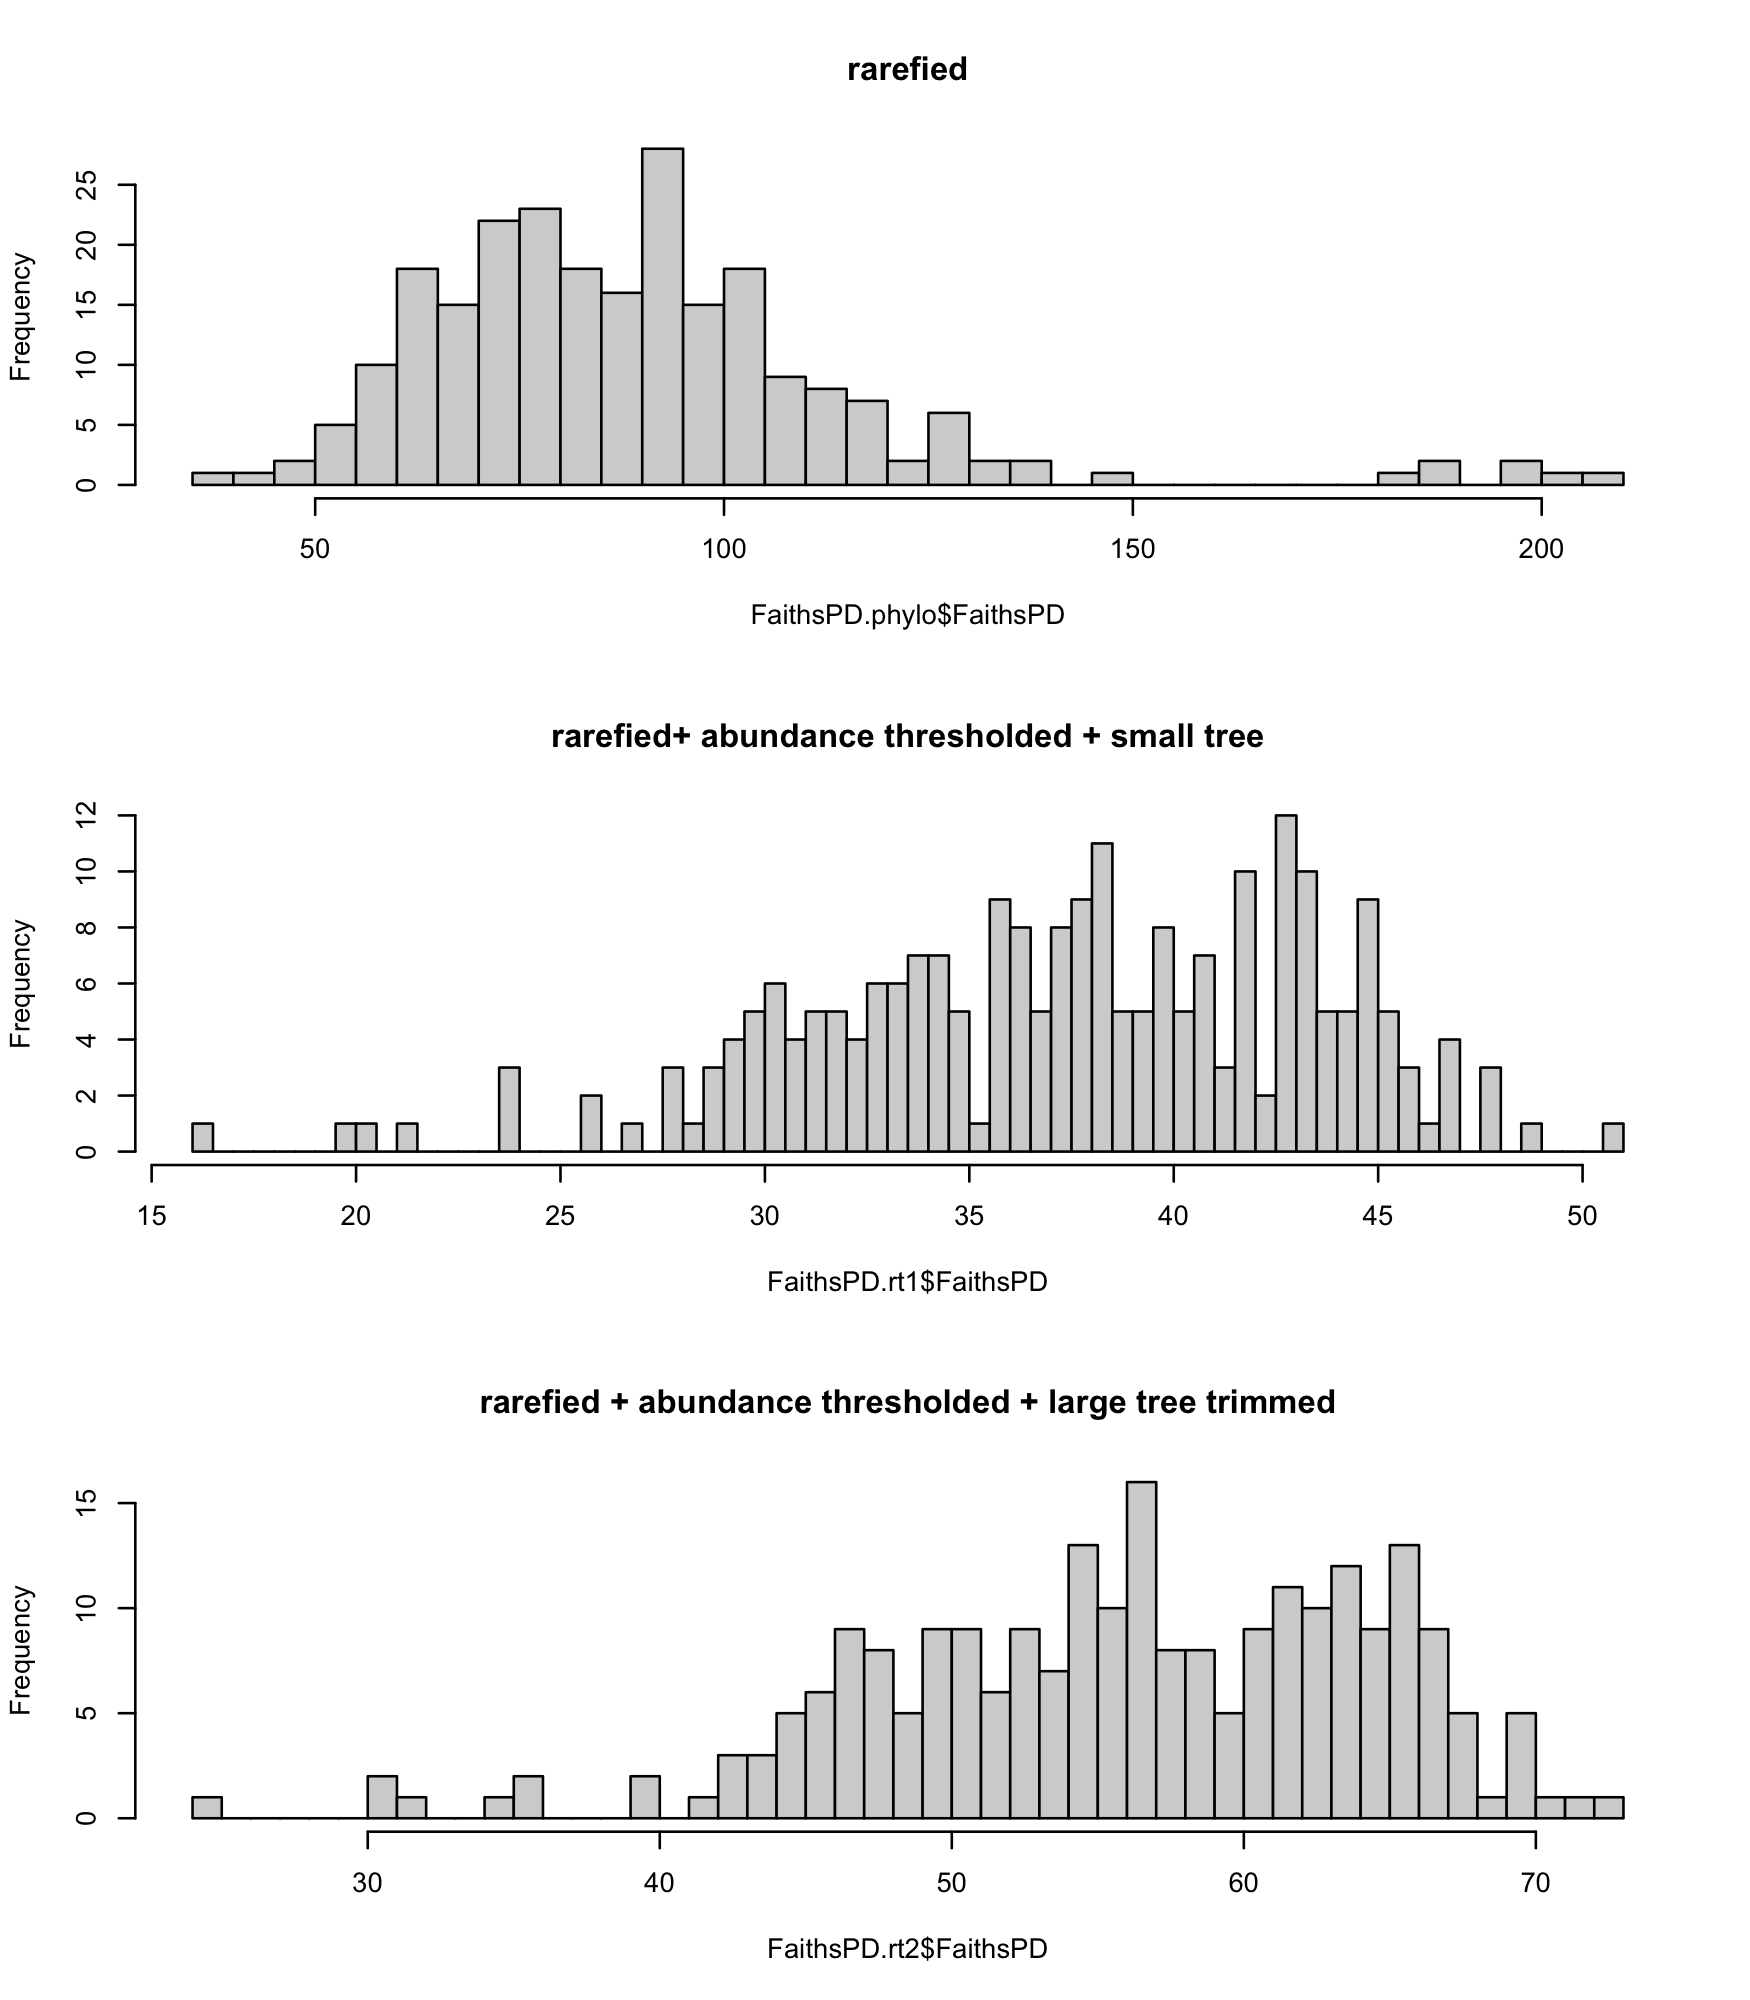

In [34]:
tree_dir = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/phylogenetic_tree'

tree_file = paste(tree_dir, "RAxML_rootedTree.root.query_all_abund.2.ref.tre", sep="/")
tree_obj.f = read_tree(tree_file, errorIfNULL=T)
TREE.clean = prune_taxa(taxa=colnames(OTU.clean), tree_obj.f)
physeq.phylo = phyloseq(OTU.table.clean, TAX.table.clean, envdata, TREE.clean)
physeq.phylo
FaithsPD.phylo = pd(OTU.clean, TREE.clean, include.root=TRUE)
colnames(FaithsPD.phylo) <- c('FaithsPD', 'Observed.ASVs')


tree_file2 = paste(tree_dir, "RAxML_rootedTree.root.query_high_abund.2.ref.tre", sep="/")
tree_obj.s = read_tree(tree_file2, errorIfNULL=T)
TREE.clean.rt1 = prune_taxa(taxa=colnames(OTU.clean.rar.thresh), tree_obj.s)
physeq.rt1 = phyloseq(OTU.table.clean.rar.t, TAX.table.clean.rar.t, envdata, TREE.clean.rt1)
physeq.rt1
TREE.clean.rt2 = prune_taxa(taxa=colnames(OTU.clean.rar.thresh), tree_obj.f)
physeq.rt2 = phyloseq(OTU.table.clean.rar.t, TAX.table.clean.rar.t, envdata, TREE.clean.rt2)
physeq.rt2

FaithsPD.rt1 = pd(OTU.clean.rar.thresh, TREE.clean.rt1, include.root=TRUE)
colnames(FaithsPD.rt1) <- c('FaithsPD', 'Observed.ASVs')

FaithsPD.rt2 = pd(OTU.clean.rar.thresh, TREE.clean.rt2, include.root=TRUE)
colnames(FaithsPD.rt2) <- c('FaithsPD', 'Observed.ASVs')


options(repr.plot.width=7, repr.plot.height=8, repr.plot.res=250)
par(mfrow=c(3,1))
hist(FaithsPD.phylo$FaithsPD, breaks=50, main='rarefied')
hist(FaithsPD.rt1$FaithsPD, breaks=50, main='rarefied+ abundance thresholded + small tree')
hist(FaithsPD.rt2$FaithsPD, breaks=50, main='rarefied + abundance thresholded + large tree trimmed')


In [ ]:

FaithsPD = pd(OTU.clean, tree_obj, include.root=TRUE)
colnames(FaithsPD) <- c('FaithsPD', 'Observed.ASVs')

enspie_fxn <- function(counts){ 1/(sum((counts/sum(counts))*(counts/sum(counts))))}
ENSpie <- as.data.frame(apply(OTU.clean, MAR=1, FUN=enspie_fxn))
colnames(ENSpie) <- c('ENSpie')

alpha_alt <- estimate_richness(physeq2, split = TRUE, measures = c("Chao1", "ACE", 'InvSimpson'))
alpha_alt = alpha_alt[,c("Chao1", "ACE", 'InvSimpson')]
alpha_alt = cbind.data.frame(alpha_alt, ENSpie, FaithsPD)


In [5]:
all_alpha = cbind.data.frame(envdata, alpha_alt)
full_data_file = paste(data_dir, "Transformed_WQVars_Hab_and_aDiv.txt", sep="/")
write.table(all_alpha, file=full_data_file, sep="\t")

cor(alpha_alt)
class(all_alpha$ENSpie)


,Chao1,ACE,InvSimpson,ENSpie,FaithsPD,Observed.ASVs
Chao1,1.0000000,0.9956596,0.4839554,0.4839554,0.5644680,0.9692231
ACE,0.9956596,1.0000000,0.4909079,0.4909079,0.5555827,0.9724471
InvSimpson,0.4839554,0.4909079,1.0000000,1.0000000,0.3856074,0.5955758
ENSpie,0.4839554,0.4909079,1.0000000,1.0000000,0.3856074,0.5955758
FaithsPD,0.5644680,0.5555827,0.3856074,0.3856074,1.0000000,0.5783242
Observed.ASVs,0.9692231,0.9724471,0.5955758,0.5955758,0.5783242,1.0000000


[1] "numeric"

In [6]:
predictors_avail = c('PHEO', 'TN', 'TP', 'CHLA', 'DOP', 'DON', 'NH4F', 'NO2F', 'NO3F', 'PC', 'PO4F', 
                     'DO', 'PH', 'SALINITY', 'WTEMP', 'Latitude', 'Habitat', 'StatName',
                     'WaterColumnPosition', 'LinearTime', 'FallPeak', 'Discharge_Susquehanna.15',
                      'Discharge_Sum.15', 'DayLength', 'Microbial.Clusters')

predictors_avail[which(!(predictors_avail %in% names(all_alpha)))]
                       
predictors_ = all_alpha[,predictors_avail]
num_cols = names(predictors_)[sapply(predictors_, class) == 'numeric']
predictors_[,num_cols] = scale(predictors_[,num_cols])
response_1 = all_alpha[,'FaithsPD']
response_2 = all_alpha[,'InvSimpson']
dim(predictors_)
length(response_1)
length(response_2)



character(0)

[1] 236  25

[1] 236

[1] 236

In [7]:
library(doParallel)
library(caret)

numCores <- 3
registerDoParallel(numCores)

ctrl <- rfeControl(functions = rfFuncs,
                   method = "repeatedcv",
                   repeats = 3,
                   number = 5,
                   verbose = T, 
                   allowParallel=T)

lmProfile <- rfe(x=predictors_, y=response_1,
                 sizes = 1:15,
                 rfeControl = ctrl)

lmProfile$fit
lmProfile$optVariables
lmProfile$bestSubset

lmProfile

stopImplicitCluster()

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘caret’


The following object is masked from ‘package:vegan’:

    tolerance





Call:
 randomForest(x = x, y = y, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 525.0196
                    % Var explained: 27.61

[1] "PO4F"               "NO2F"               "TP"                
[4] "FallPeak"           "Microbial.Clusters"

[1] 5


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables  RMSE Rsquared   MAE RMSESD RsquaredSD MAESD Selected
         1 25.29   0.2047 16.14  3.236    0.05285 1.607         
         2 24.04   0.2350 15.21  3.408    0.07912 1.506         
         3 23.60   0.2497 14.84  3.902    0.09747 1.582         
         4 23.09   0.2801 14.54  3.952    0.09501 1.396         
         5 22.75   0.2974 14.29  4.156    0.10467 1.613        *
         6 22.96   0.2921 14.56  4.178    0.11875 1.628         
         7 22.95   0.2959 14.65  4.237    0.12571 1.713         
         8 22.87   0.2987 14.56  4.183    0.11958 1.750         
         9 23.09   0.2937 14.75  4.375    0.13010 1.741         
        10 23.03   0.2982 14.69  4.500    0.13815 1.821         
        11 23.14   0.2937 14.72  4.475    0.13580 1.870         
        12 23.20   0.2908 14.73  4.410    0.12896 1.843         
        13 23

In [8]:
registerDoParallel(numCores)

ctrl <- rfeControl(functions = rfFuncs,
                   method = "repeatedcv",
                   repeats = 3,
                   number = 5,
                   verbose = T, 
                   allowParallel=T)

lmProfile <- rfe(x=predictors_, y=response_2,
                 sizes = 1:15,
                 rfeControl = ctrl)

lmProfile$fit
lmProfile$optVariables
lmProfile$bestSubset

lmProfile

stopImplicitCluster()


Call:
 randomForest(x = x, y = y, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 8

          Mean of squared residuals: 405.3783
                    % Var explained: 44.98

[1] "SALINITY"                 "LinearTime"              
 [3] "FallPeak"                 "PO4F"                    
 [5] "TP"                       "PH"                      
 [7] "Discharge_Sum.15"         "TN"                      
 [9] "DayLength"                "CHLA"                    
[11] "Habitat"                  "WTEMP"                   
[13] "Discharge_Susquehanna.15" "PHEO"                    
[15] "DON"                      "NO2F"                    
[17] "NO3F"                     "DO"                      
[19] "PC"                       "Latitude"                
[21] "Microbial.Clusters"       "NH4F"                    
[23] "WaterColumnPosition"      "StatName"                
[25] "DOP"

[1] 25


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables  RMSE Rsquared   MAE RMSESD RsquaredSD MAESD Selected
         1 23.75   0.2964 17.63  4.778    0.08695 2.361         
         2 21.03   0.4019 15.07  5.703    0.13652 2.321         
         3 20.18   0.4407 14.59  5.772    0.16603 2.180         
         4 20.61   0.4194 14.69  5.289    0.13668 1.902         
         5 20.67   0.4173 14.60  5.386    0.15540 2.078         
         6 20.59   0.4297 14.40  5.381    0.15003 1.953         
         7 20.84   0.4198 14.51  5.419    0.16267 2.128         
         8 20.62   0.4243 14.44  5.253    0.15087 1.995         
         9 20.76   0.4221 14.46  5.220    0.15413 2.004         
        10 20.42   0.4354 14.29  5.155    0.15272 1.935         
        11 20.31   0.4425 14.30  5.185    0.15031 2.023         
        12 20.20   0.4511 14.19  5.199    0.15267 2.040         
        13 20

In [7]:
library(nortest)
ad.test(response_1)
ad.test(response_2)
xform_const = powerTransform(lm(response_1~1))$lambda
response_1.1 = ((response_1^xform_const) - 1)/xform_const
ad.test(response_1.1)
print(xform_const)


xform_const2 = powerTransform(lm(response_2~1))$lambda
response_2.1 = ((response_2^xform_const2) - 1)/xform_const2
ad.test(response_2.1)
print(xform_const2)
pred_resp_f = cbind.data.frame(predictors_, response_1.1)
colnames(pred_resp_f) <- c(colnames(predictors_), 'FaithsPD')
pred_resp_f <- pred_resp_f[complete.cases(pred_resp_f),]
colSums(is.na(pred_resp_f))
pred_resp_i = cbind.data.frame(predictors_, response_2)
colnames(pred_resp_i) <- c(colnames(predictors_), 'InvSimpson')
pred_resp_i <- pred_resp_i[complete.cases(pred_resp_i),]
colSums(is.na(pred_resp_i))



	Anderson-Darling normality test

data:  response_1
A = 5.4112, p-value = 2.189e-13



	Anderson-Darling normality test

data:  response_2
A = 2.3591, p-value = 5.483e-06



	Anderson-Darling normality test

data:  response_1.1
A = 0.68199, p-value = 0.07401


        Y1 
-0.4297588 



	Anderson-Darling normality test

data:  response_2.1
A = 0.33347, p-value = 0.5079


       Y1 
0.3225214 


PHEO                       TN                       TP 
                       0                        0                        0 
                    CHLA                      DOP                      DON 
                       0                        0                        0 
                    NH4F                     NO2F                     NO3F 
                       0                        0                        0 
                      PC                     PO4F                       DO 
                       0                        0                        0 
                      PH                 SALINITY                    WTEMP 
                       0                        0                        0 
                Latitude                  Habitat                 StatName 
                       0                        0                        0 
     WaterColumnPosition               LinearTime                 FallPeak 
                       0                        0                        0 
Discharge_Susquehanna.15         Discharge_Sum.15                DayLength 
                       0                        0                        0 
      Microbial.Clusters                 FaithsPD 
                       0                        0

PHEO                       TN                       TP 
                       0                        0                        0 
                    CHLA                      DOP                      DON 
                       0                        0                        0 
                    NH4F                     NO2F                     NO3F 
                       0                        0                        0 
                      PC                     PO4F                       DO 
                       0                        0                        0 
                      PH                 SALINITY                    WTEMP 
                       0                        0                        0 
                Latitude                  Habitat                 StatName 
                       0                        0                        0 
     WaterColumnPosition               LinearTime                 FallPeak 
                       0                        0                        0 
Discharge_Susquehanna.15         Discharge_Sum.15                DayLength 
                       0                        0                        0 
      Microbial.Clusters               InvSimpson 
                       0                        0

In [8]:
upper_model = lm(InvSimpson ~ ., data=pred_resp_i)
lower_model = lm(InvSimpson ~ 1, data=pred_resp_i)
n = length(resid(lower_model))

fbstep_invsimp = stepAIC(lower_model, scope=formula(upper_model), 
                         scale = 0, direction = 'both', trace=1, k=log(n))
length(colnames(fbstep_invsimp$model))
extractAIC(fbstep_invsimp)
colnames(fbstep_invsimp$model)


Start:  AIC=1563.59
InvSimpson ~ 1

                           Df Sum of Sq    RSS    AIC
+ Habitat                   2     38616 135253 1515.2
+ WaterColumnPosition       1     21926 151943 1537.2
+ SALINITY                  1     20349 153519 1539.7
+ PHEO                      1     19748 154121 1540.6
+ PO4F                      1     18629 155240 1542.3
+ Microbial.Clusters        2     20139 153730 1545.5
+ TP                        1     15548 158320 1546.9
+ NO2F                      1     11554 162315 1552.8
+ FallPeak                  1     11447 162422 1553.0
+ DayLength                 1     10929 162940 1553.7
+ NH4F                      1      9586 164283 1555.7
+ CHLA                      1      9374 164495 1556.0
+ Discharge_Sum.15          1      8743 165125 1556.9
+ Discharge_Susquehanna.15  1      7687 166182 1558.4
+ DON                       1      7235 166634 1559.0
<none>                                  173869 1563.6
+ Latitude                  1      2937 170932


Step:  AIC=1477.88
InvSimpson ~ Habitat + DayLength + TP + WTEMP + Discharge_Susquehanna.15 + 
    Latitude

                           Df Sum of Sq    RSS    AIC
+ DO                        1    5840.2  96988 1469.5
+ TN                        1    5321.3  97507 1470.8
+ PHEO                      1    5057.9  97770 1471.4
+ PC                        1    4989.7  97838 1471.6
+ NO2F                      1    4018.8  98809 1473.9
+ NO3F                      1    3446.5  99382 1475.3
- DayLength                 1    2379.4 105208 1477.8
<none>                                  102828 1477.9
+ DOP                       1    2278.5 100550 1478.0
+ PH                        1    1953.1 100875 1478.8
+ PO4F                      1    1435.3 101393 1480.0
+ SALINITY                  1     491.6 102336 1482.2
- Latitude                  1    4515.4 107343 1482.6
+ CHLA                      1     205.7 102622 1482.9
+ DON                       1     110.8 102717 1483.1
+ Discharge_Sum.15        


Step:  AIC=1453.39
InvSimpson ~ TP + WTEMP + Discharge_Susquehanna.15 + Latitude + 
    DO + NO2F + PHEO + CHLA

                           Df Sum of Sq    RSS    AIC
<none>                                   90570 1453.4
+ DON                       1    1350.8  89219 1455.3
- CHLA                      1    2927.5  93498 1455.4
+ DOP                       1    1219.8  89350 1455.7
+ SALINITY                  1     901.0  89669 1456.5
+ NH4F                      1     831.7  89738 1456.7
+ WaterColumnPosition       1     601.1  89969 1457.3
- NO2F                      1    3971.7  94542 1458.0
+ PC                        1     239.7  90330 1458.2
+ TN                        1     235.1  90335 1458.2
+ NO3F                      1     105.1  90465 1458.6
+ DayLength                 1      52.8  90517 1458.7
+ LinearTime                1      17.8  90552 1458.8
+ FallPeak                  1      15.1  90555 1458.8
+ PO4F                      1      10.5  90560 1458.8
+ Discharge_Sum.15    

[1] 9

[1]    9.000 1422.211

[1] "InvSimpson"               "TP"                      
[3] "WTEMP"                    "Discharge_Susquehanna.15"
[5] "Latitude"                 "DO"                      
[7] "NO2F"                     "PHEO"                    
[9] "CHLA"

In [9]:
abs(cor(apply(pred_resp_i[,colnames(fbstep_invsimp$model)], 2, as.numeric))) > 0.65

,InvSimpson,TP,WTEMP,Discharge_Susquehanna.15,Latitude,DO,NO2F,PHEO,CHLA
InvSimpson,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
TP,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WTEMP,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE
Discharge_Susquehanna.15,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE
Latitude,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
DO,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE
NO2F,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE
PHEO,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
CHLA,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE


In [10]:
eM1 <- lm(InvSimpson~TP + WTEMP + Discharge_Susquehanna.15 + Latitude + NO2F + CHLA, data=pred_resp_i)
eM2 <- lm(InvSimpson~TP + WTEMP + Discharge_Susquehanna.15 + Latitude + NO2F + DO, data=pred_resp_i)
eM3 <- lm(InvSimpson~TP + WTEMP + Discharge_Susquehanna.15 + Latitude + NO2F + PHEO, data=pred_resp_i)
eM4 <- lm(InvSimpson~TP + WTEMP + Discharge_Susquehanna.15 + Latitude + DO, data=pred_resp_i)
eM5 <- lm(InvSimpson~TP + WTEMP + Discharge_Susquehanna.15 + Latitude + PHEO, data=pred_resp_i)
anova(eM1, eM2, eM3, eM4, eM5)
AIC(eM1, eM2, eM3, eM4, eM5)
summary(eM2)
drop1(eM2, test="F")
coef(eM2)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,229,102362.56,NA,NA,NA,NA
2,229,96147.50,0,6215.058,NA,NA
3,229,97910.62,0,-1763.115,NA,NA
4,230,107361.70,-1,-9451.082,21.14345,7.049377e-06
5,230,101412.99,0,5948.707,NA,NA


,df,AIC
,<dbl>,<dbl>
eM1,8,2118.836
eM2,8,2104.053
eM3,8,2108.342
eM4,7,2128.089
eM5,7,2114.636



Call:
lm(formula = InvSimpson ~ TP + WTEMP + Discharge_Susquehanna.15 + 
    Latitude + NO2F + DO, data = pred_resp_i)

Residuals:
    Min      1Q  Median      3Q     Max 
-52.415 -12.414   0.537  10.534 133.348 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)                64.597      1.334  48.430  < 2e-16 ***
TP                         19.691      2.164   9.099  < 2e-16 ***
WTEMP                     -25.200      3.160  -7.974 7.28e-14 ***
Discharge_Susquehanna.15  -22.177      3.265  -6.792 9.43e-11 ***
Latitude                  -16.549      1.817  -9.107  < 2e-16 ***
NO2F                        9.042      1.750   5.168 5.14e-07 ***
DO                          8.913      1.924   4.632 6.07e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.49 on 229 degrees of freedom
Multiple R-squared:  0.447,	Adjusted R-squared:  0.4325 
F-statistic: 30.85 on 6 and 229 DF,  p-value: < 2.2e-16


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,96147.5,1432.314,NA,NA
TP,1,34760.25,130907.8,1503.146,82.79047,4.553058e-17
WTEMP,1,26696.24,122843.7,1488.141,63.58396,7.276976e-14
Discharge_Susquehanna.15,1,19367.81,115515.3,1473.625,46.12941,9.432343e-11
Latitude,1,34820.40,130967.9,1503.255,82.93373,4.317102e-17
NO2F,1,11214.20,107361.7,1456.350,26.70949,5.144990e-07
DO,1,9009.58,105157.1,1451.453,21.45863,6.065147e-06


(Intercept)                       TP                    WTEMP 
               64.597133                19.691238               -25.199867 
Discharge_Susquehanna.15                 Latitude                     NO2F 
              -22.177288               -16.549181                 9.041779 
                      DO 
                8.913206

In [11]:
library(caret)
options(repr.plot.width=4, repr.plot.height=3)

vf3 <- varIdent(form= ~ WaterColumnPosition)
vf2 <- varIdent(form= ~ Microbial.Clusters)

print("linear unweighted model")
envM1 <- lm(InvSimpson ~ TP + WTEMP + Discharge_Susquehanna.15 + Habitat + Latitude, data=pred_resp_i)
postResample(pred = predict(envM1), obs = pred_resp_i$InvSimpson)

print("linear weighted model")
evM5 <- gls(InvSimpson~ TP + WTEMP + Discharge_Susquehanna.15 + NO2F + DO, data=pred_resp_i, weights=vf3)
postResample(pred = predict(evM5), obs = pred_resp_i$InvSimpson)

print("linear weighted model2")
envM3 <- gls(InvSimpson~ TP + WTEMP + Discharge_Susquehanna.15 + NO2F + DO, data=pred_resp_i, weights=vf2)
postResample(pred = predict(envM3), obs = pred_resp_i$InvSimpson)

print("nonlinear unweighted model")
envM2 <- gam(InvSimpson ~ s(TP, bs = "cs")  + s(WTEMP, bs = "cs") + s(Discharge_Susquehanna.15, bs = "cs") 
             + s(NO2F, bs = "cs") + s(DO, bs = "cs") + s(Latitude, bs="cs"), data=pred_resp_i)
postResample(pred = predict(envM2), obs = pred_resp_i$InvSimpson)

print("nonlinear weighted model1")
envM4 <- gamm(InvSimpson ~ s(TP, bs = "cs")  + s(WTEMP, bs = "cs") + s(Discharge_Susquehanna.15, bs = "cs") 
             + s(NO2F, bs = "cs") + s(DO, bs = "cs"), weights=vf3, data=pred_resp_i)
postResample(pred = predict(envM4$gam), obs = pred_resp_i$InvSimpson)

print("nonlinear weighted model2")
envM5 <- gamm(InvSimpson ~ s(TP, bs = "cs")  + s(WTEMP, bs = "cs") + s(Discharge_Susquehanna.15, bs = "cs") 
             + s(NO2F, bs = "cs") + s(DO, bs = "cs"), weights=vf2, data=pred_resp_i)
postResample(pred = predict(envM5$gam), obs = pred_resp_i$InvSimpson)

#AIC(envM4$lme)
#plot(envM3$gam)
summary(envM2)
#anova(envM2)

[1] "linear unweighted model"


ERROR: Error in postResample(pred = predict(envM1), obs = pred_resp_i$InvSimpson): could not find function "postResample"



Family: gaussian 
Link function: identity 

Formula:
InvSimpson ~ s(TP, bs = "cs", k = 8) + s(WTEMP, bs = "cs", k = 8) + 
    s(DO, bs = "cs") + Discharge_Susquehanna.15 + NO2F + s(SALINITY, 
    bs = "cs", k = 6)

Parametric coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               7.747e+01  4.672e+00  16.582  < 2e-16 ***
Discharge_Susquehanna.15 -2.693e-05  8.401e-06  -3.206  0.00155 ** 
NO2F                      9.869e+01  4.891e+01   2.018  0.04485 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df      F  p-value    
s(TP)       4.149      7  8.306 5.52e-12 ***
s(WTEMP)    2.821      7  5.774 1.77e-09 ***
s(DO)       2.615      9  2.770 1.89e-06 ***
s(SALINITY) 4.288      5 11.653 1.10e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.481   Deviance explained = 51.7%
GCV = 412.91  Scale est. = 382.74  

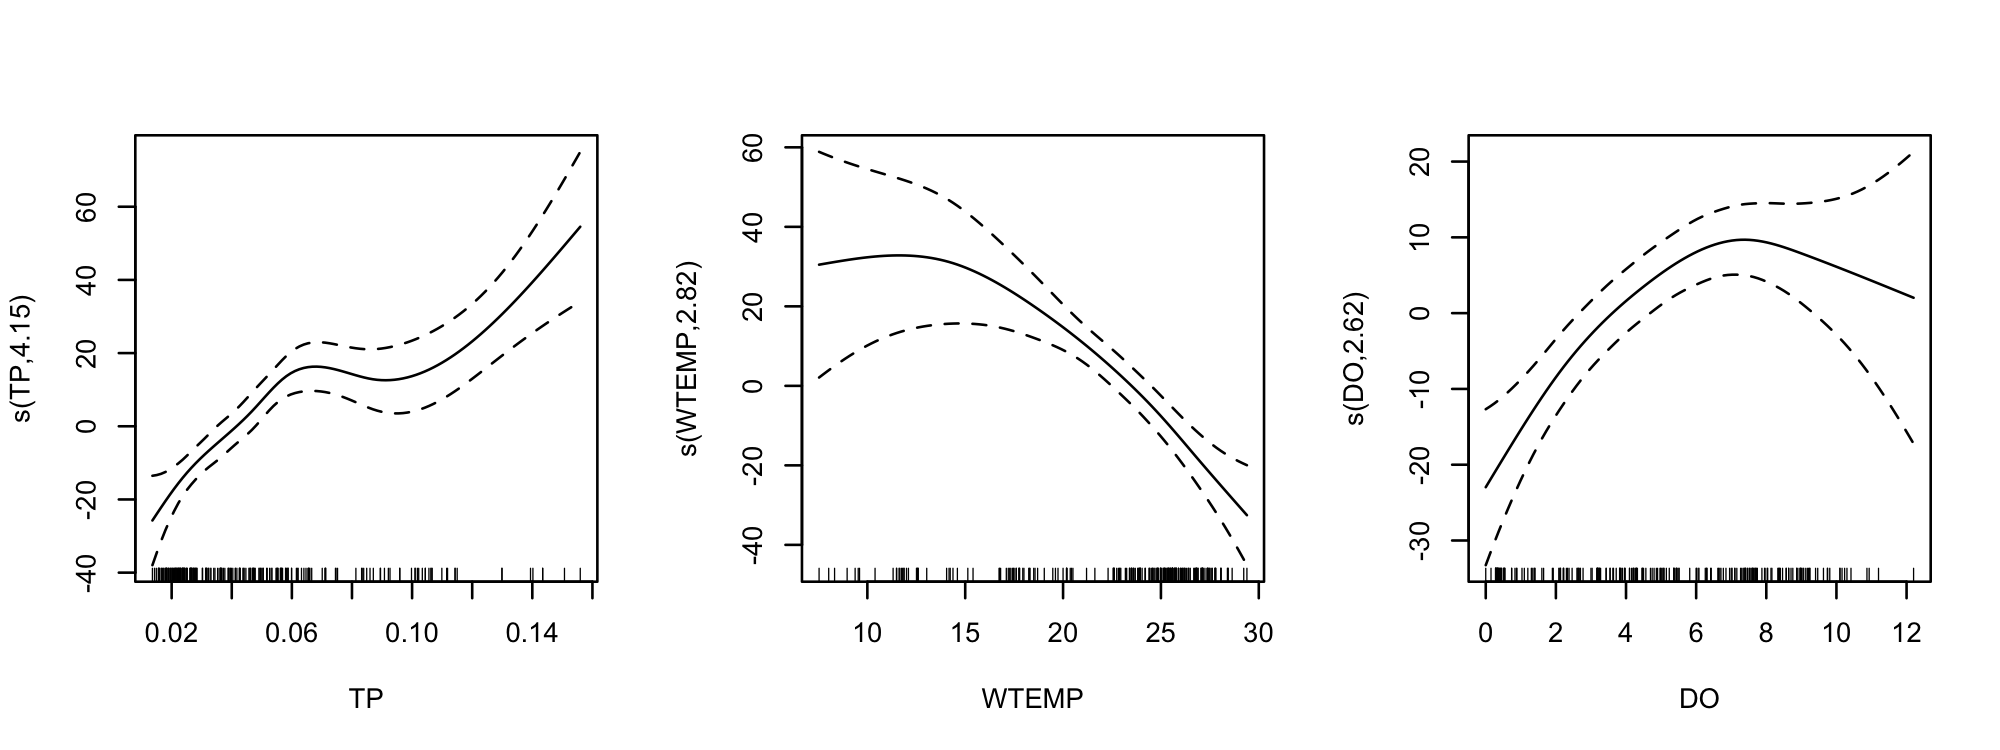

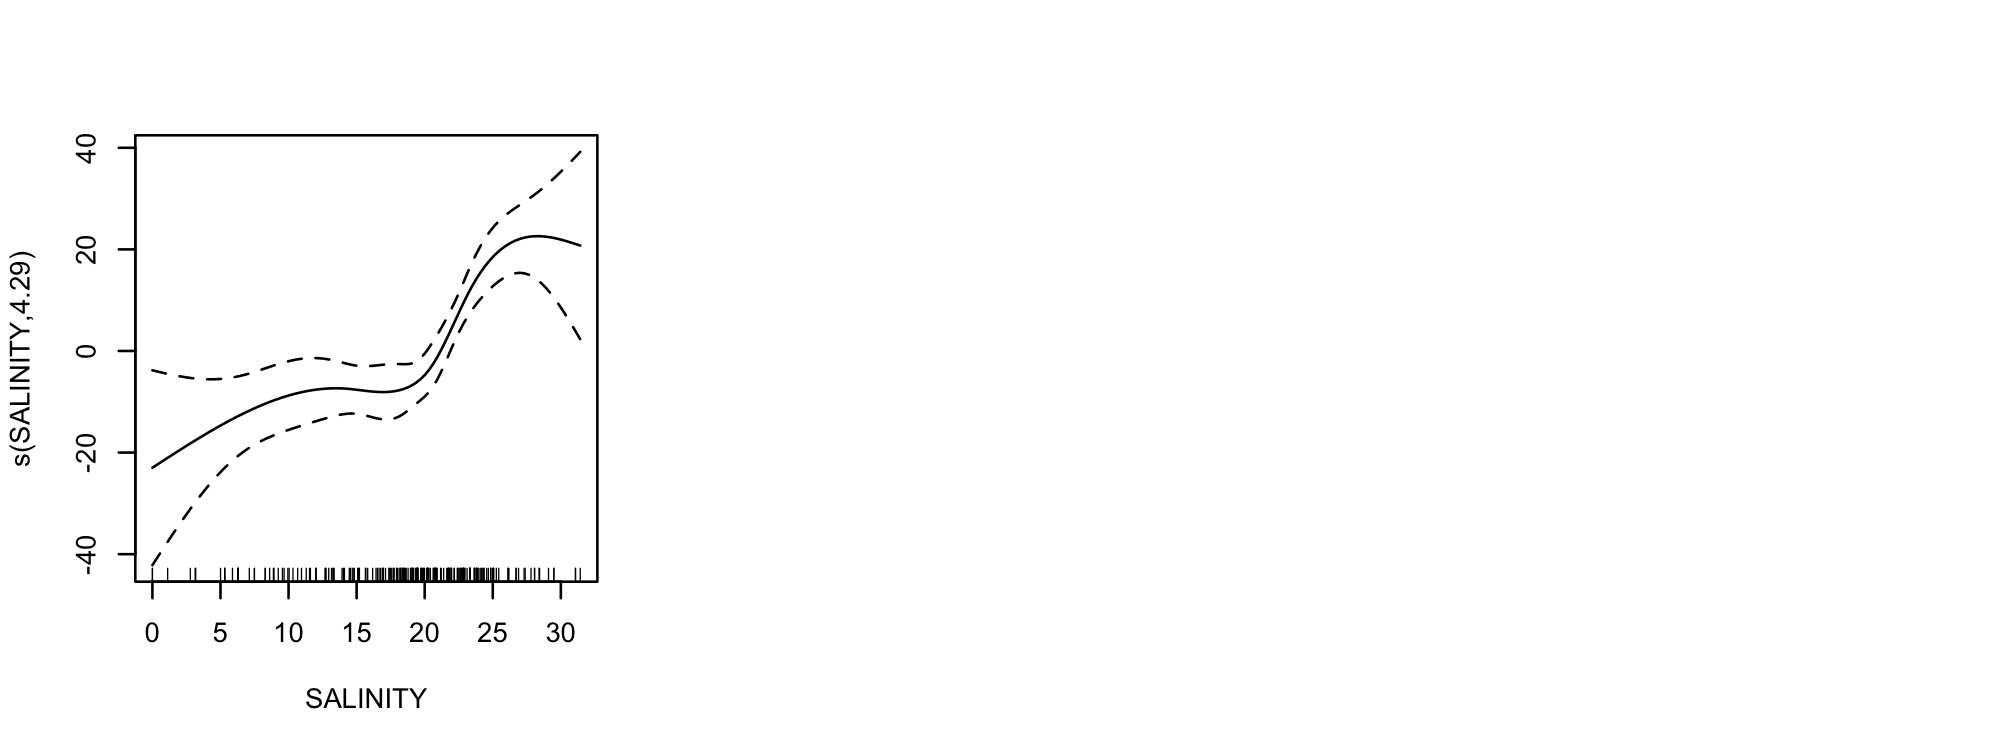

In [31]:

selected_predictors1 = c('TP', 'WTEMP', 'Discharge_Susquehanna.15', 'NO2F', 'DO', 'Latitude',
                         'cruise_id', 'SALINITY')
selected_predictors2 = c('Habitat', 'StatName')
selected_response = c('InvSimpson')
obs_df = cbind.data.frame(envdata_pre[,selected_predictors1], envdata[,selected_predictors2], 
                          response_2)
colnames(obs_df) = c(selected_predictors1, selected_predictors2, selected_response)
obs_df <- obs_df[complete.cases(obs_df),]
envM2 <- gam(InvSimpson ~ s(TP, bs = "cs", k=8)  + s(WTEMP, bs = "cs", k=8) + s(DO, bs = "cs")
             + Discharge_Susquehanna.15 + NO2F + s(SALINITY, bs = "cs", k=6), data=obs_df)
              
summary(envM2)
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res = 250)
par(mfrow=c(1,3))
plot.gam(envM2, scale=0)



	Anderson-Darling normality test

data:  resid(envM2)
A = 1.3279, p-value = 0.001875


[1] "SB041117TAWCSCB31D13BR1TR1I289"

,SB041117TAWCSCB31D13BR1TR1I289
TP,0.1507
WTEMP,9.533333
Discharge_Susquehanna.15,1847369
NO2F,0.0133
DO,7.266667
Latitude,39.2495
cruise_id,18
SALINITY,8.886667
Habitat,H.1
StatName,1


[1] 118.455

[1] 110.4357

[1] 231  11

[1] 231

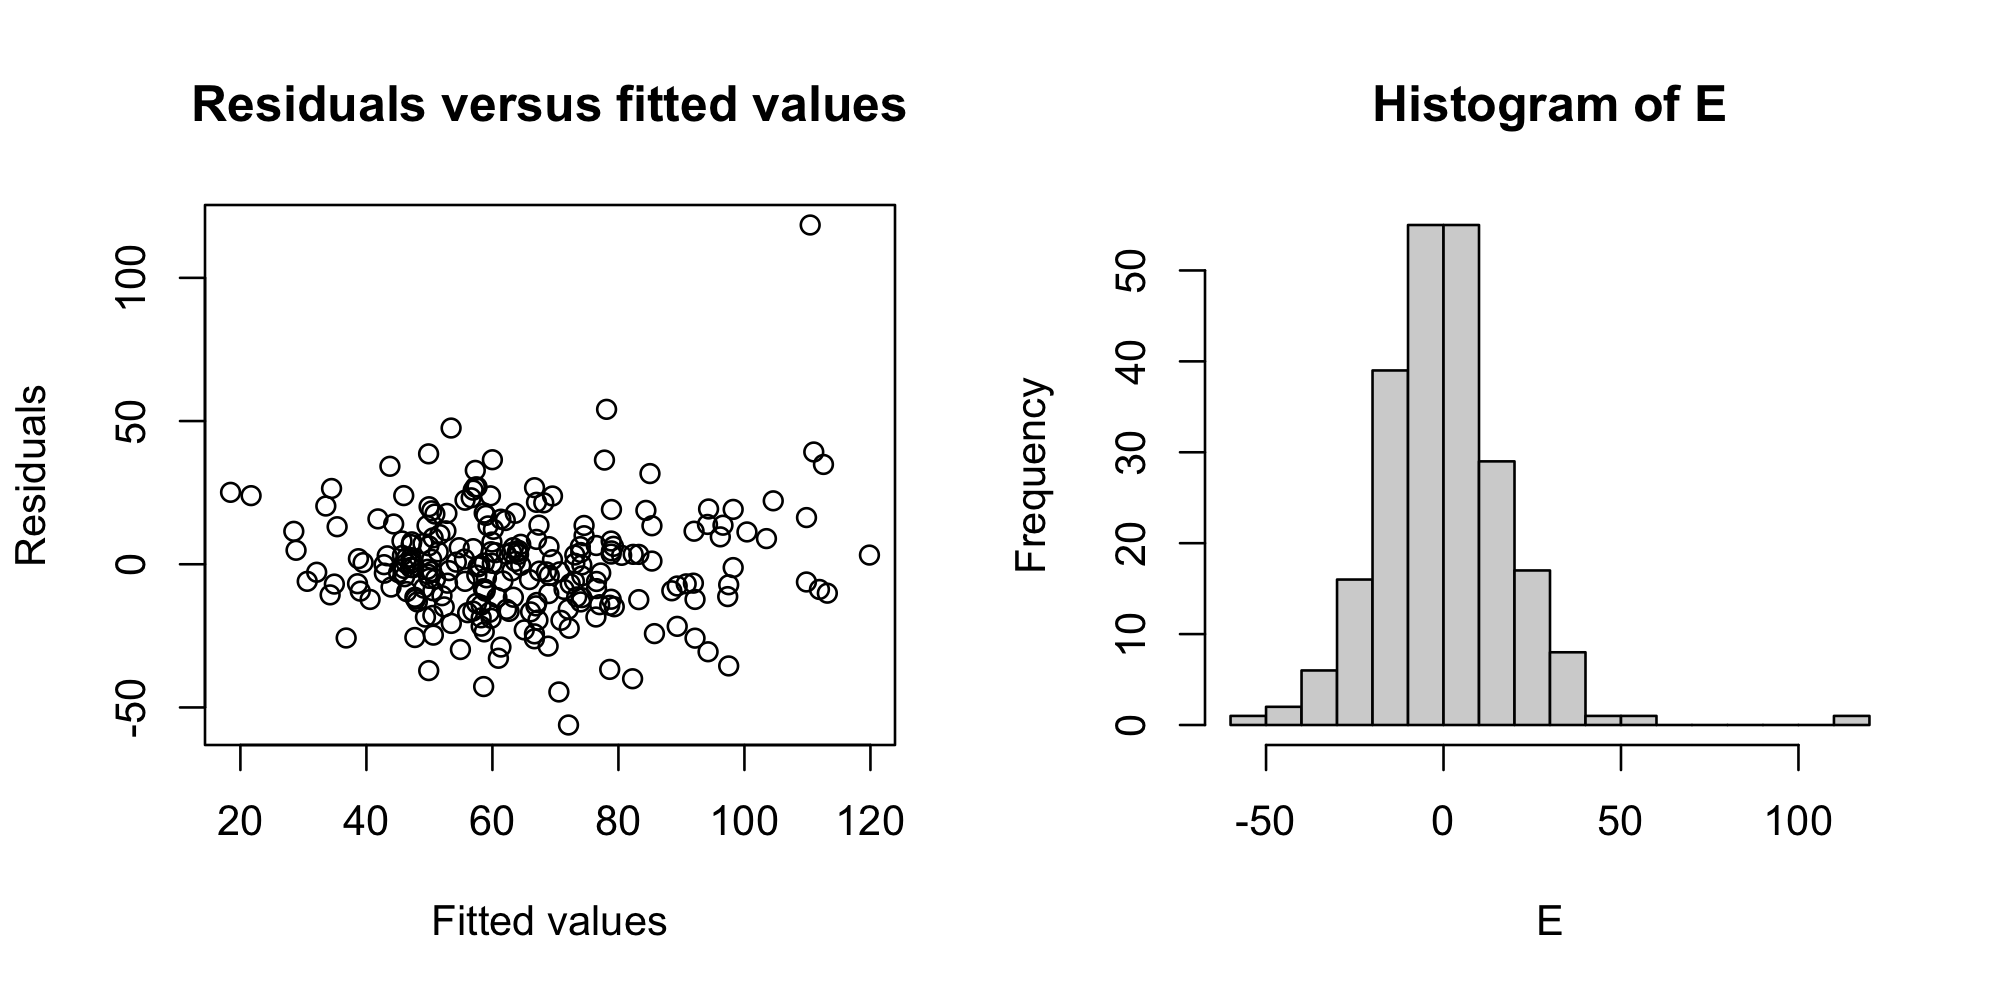

In [13]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 250)
ad.test(resid(envM2))

E <- resid(envM2)
Fit <- fitted(envM2)
op <- par(mfrow = c(1, 2))
plot(x = Fit,y = E, xlab = "Fitted values", ylab = "Residuals", main = "Residuals versus fitted values")
hist(E, nclass = 15)
par(op)

rownames(obs_df[which(E > 100),])
t(obs_df[which(E > 100),])
E[which(E > 100)]
Fit[which(E > 100)]
dim(obs_df)
length(Fit)

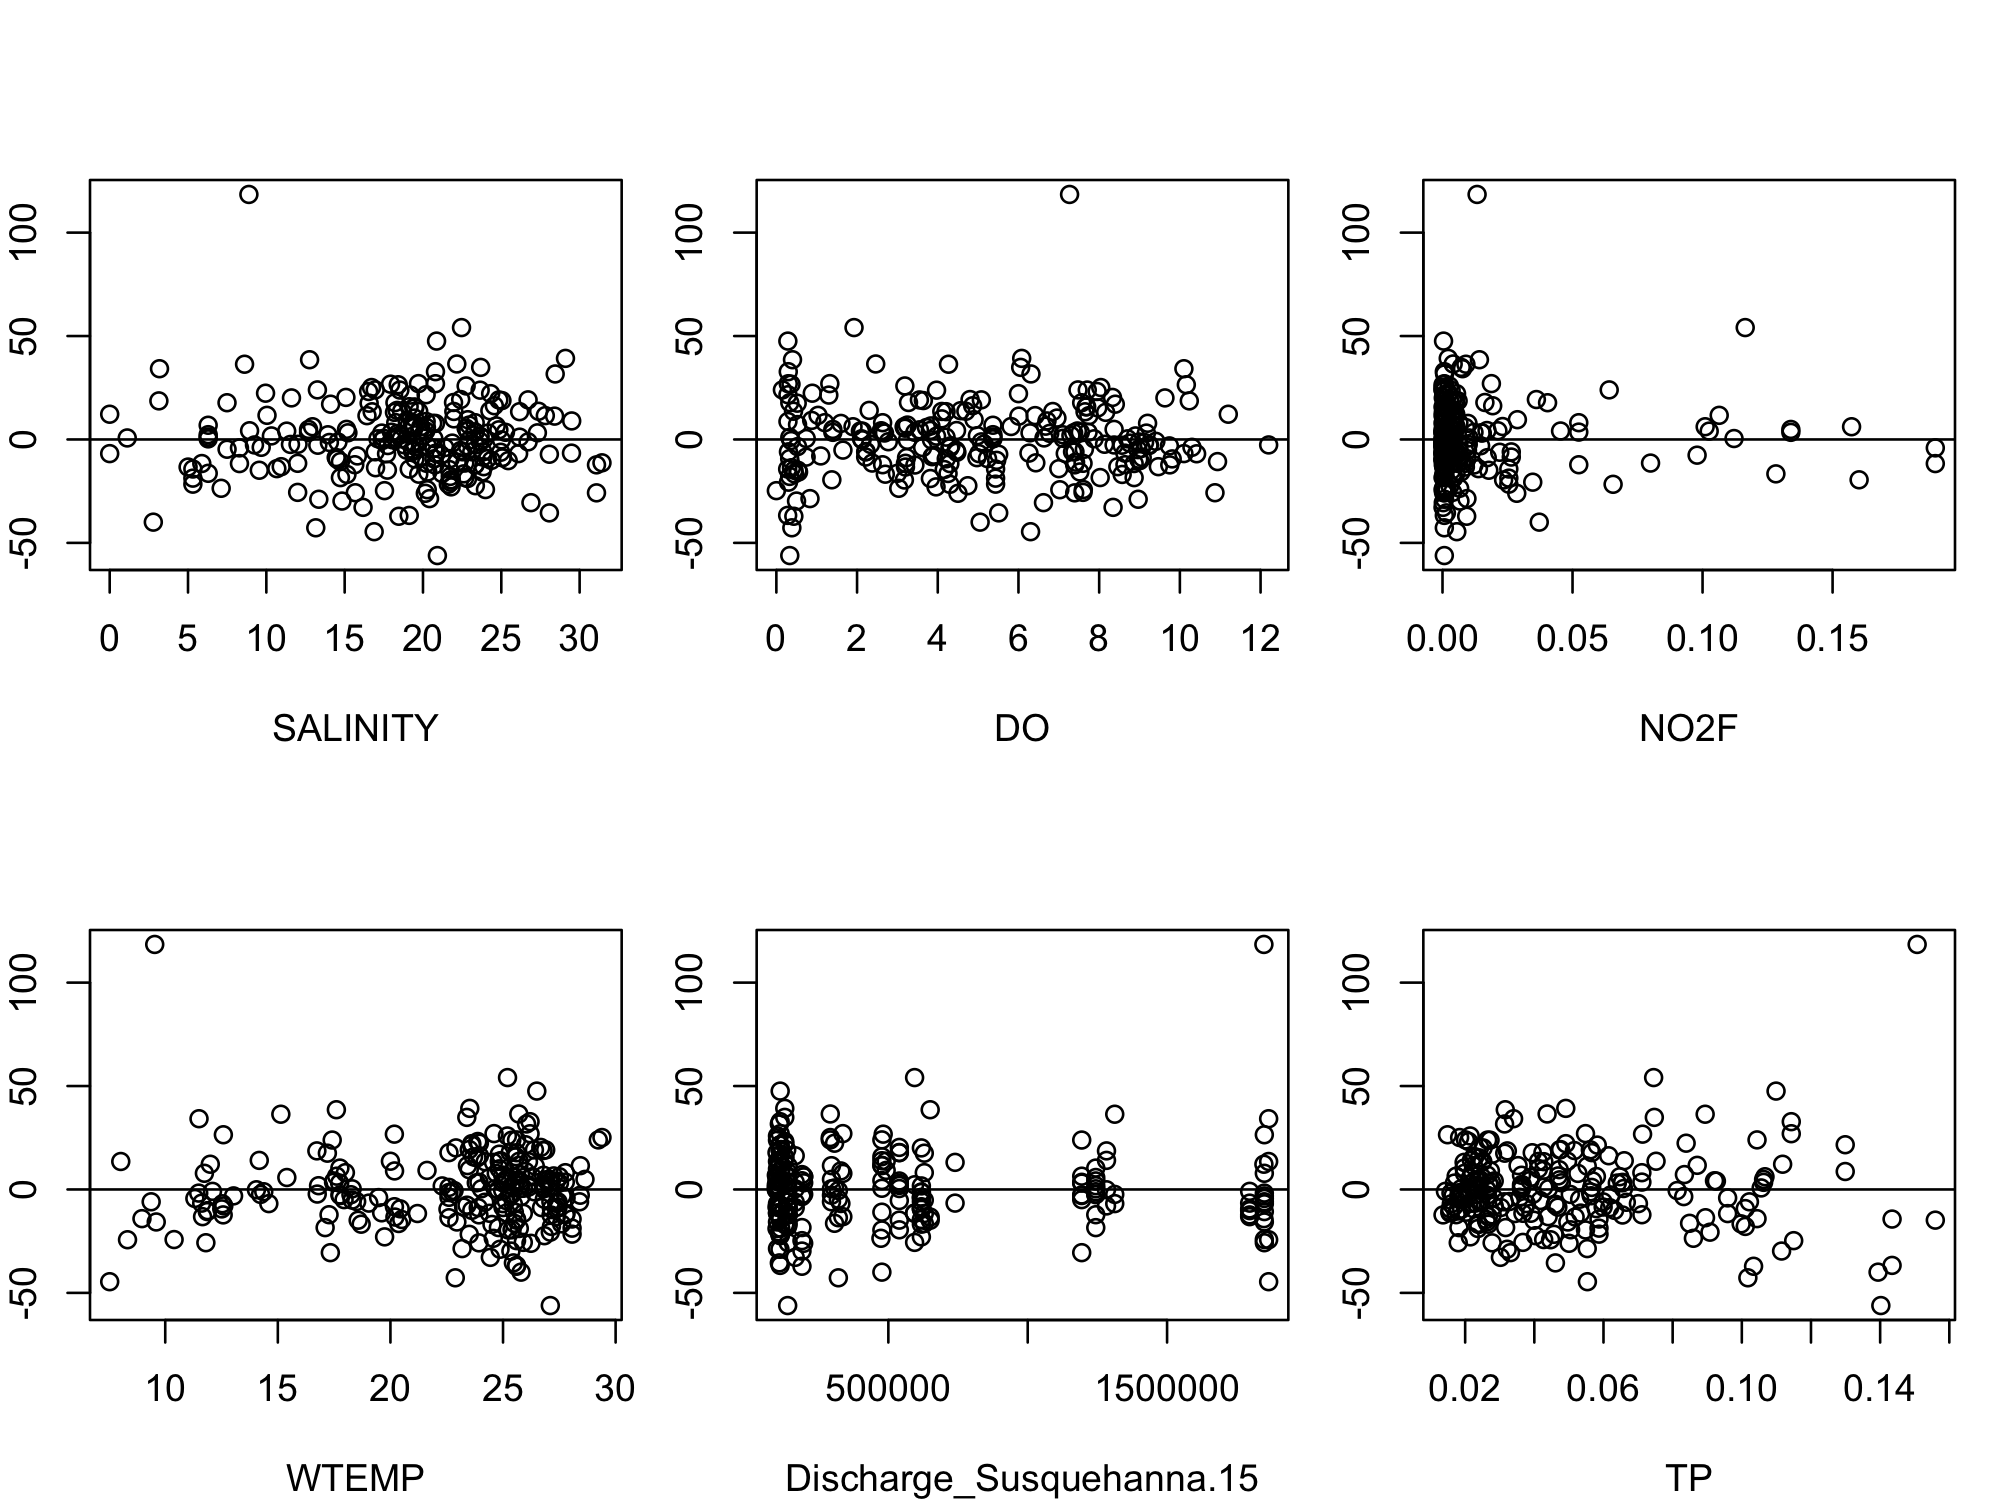

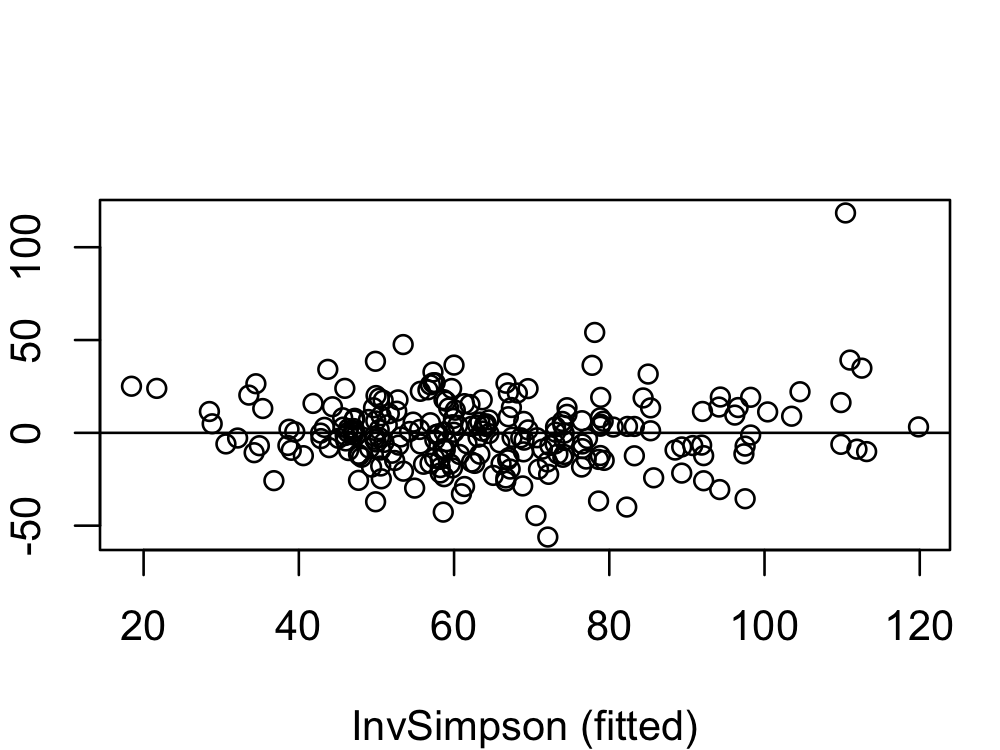

In [14]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res = 250)
par(mfrow = c(2, 3), mar=c(4,2,4,1), cex=0.9)
eE2 <- resid(envM2)

plot(y = eE2, x = obs_df$SALINITY, xlab = "SALINITY", ylab = "Residuals")
abline(0,0)
plot(eE2 ~ obs_df$DO, xlab = "DO", ylab = "Residuals")
abline(0, 0)
plot(eE2 ~ obs_df$NO2F, xlab = "NO2F", ylab = "Residuals")
abline(0, 0)
plot(eE2 ~ obs_df$WTEMP, xlab = "WTEMP", ylab = "Residuals")
abline(0, 0)
plot(eE2 ~ obs_df$Discharge_Susquehanna.15, xlab = "Discharge_Susquehanna.15", ylab = "Residuals")
abline(0, 0)
plot(eE2 ~ obs_df$TP, xlab = "TP", ylab = "Residuals")
abline(0, 0)

par(op)
options(repr.plot.width=4, repr.plot.height=3)
plot(eE2 ~ Fit, xlab = "InvSimpson (fitted)", ylab = "Residuals")
abline(0, 0)

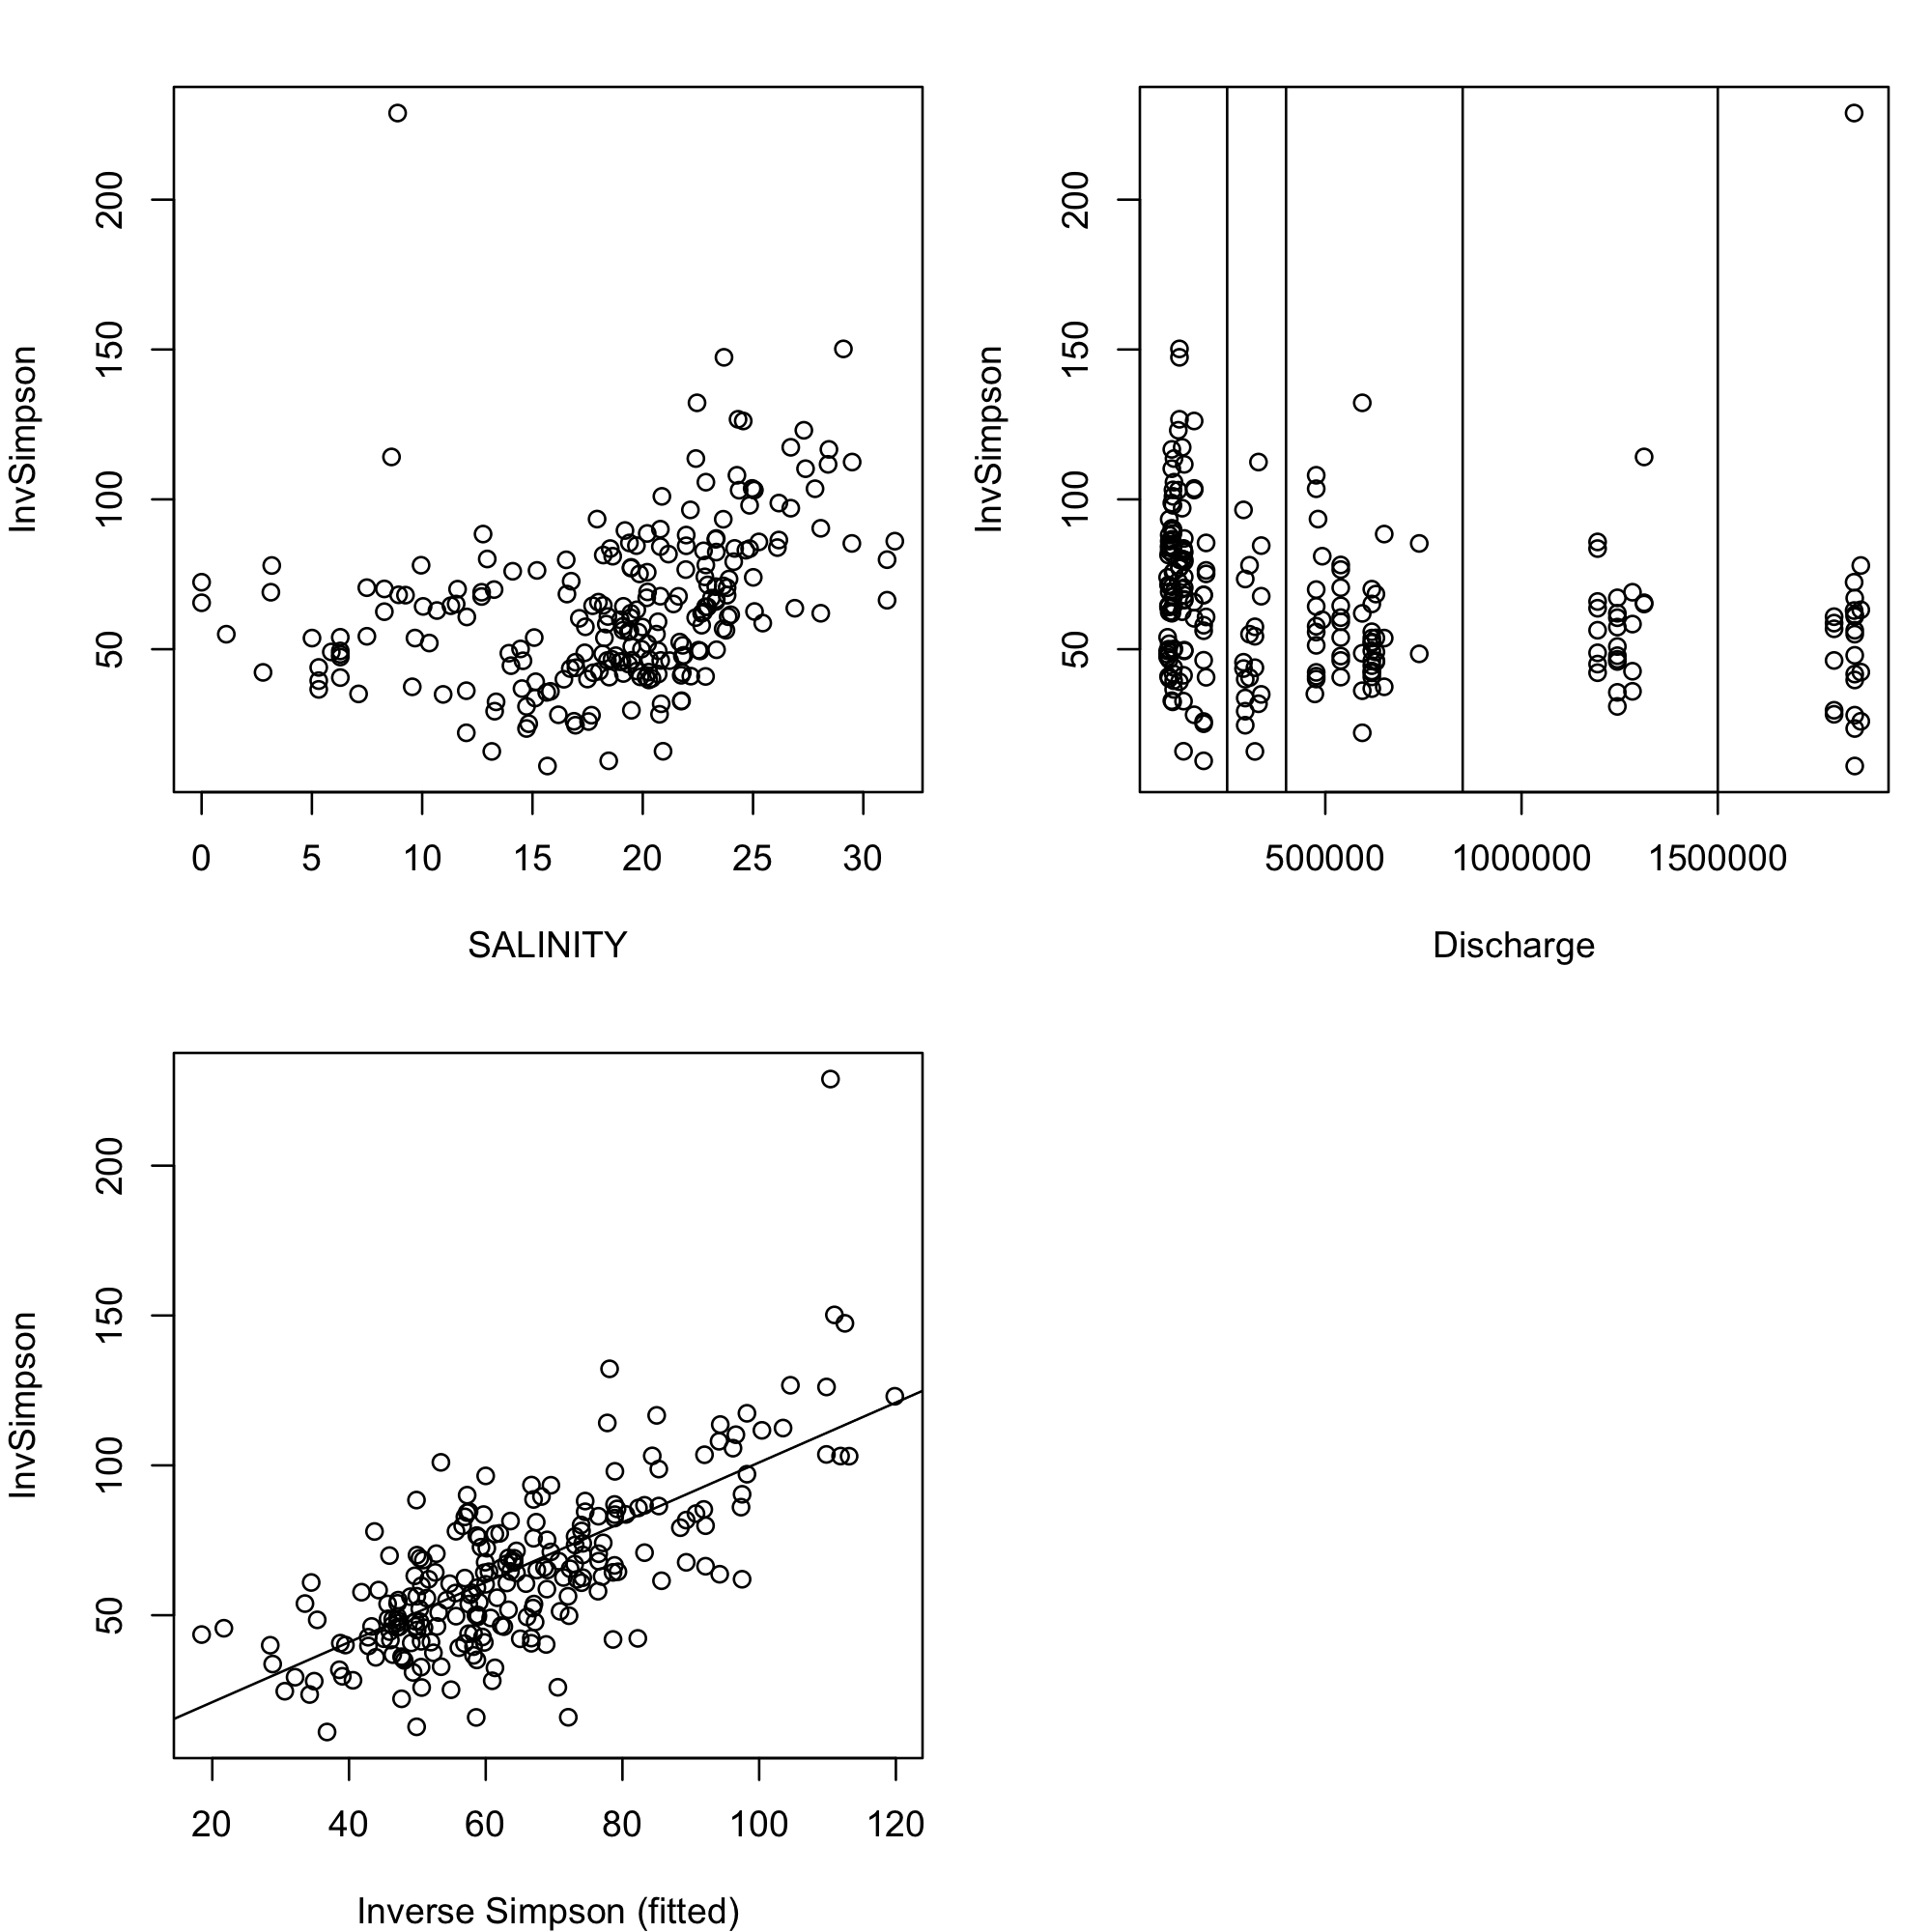

In [15]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res = 250)
par(mfrow = c(2, 2), mar=c(4,4,2,1), cex=0.9)
plot(y = obs_df$InvSimpson, x = obs_df$SALINITY, xlab = "SALINITY", ylab = "InvSimpson")
abline(0,0)
plot(obs_df$InvSimpson ~ obs_df$Discharge_Susquehanna.15, xlab = "Discharge", ylab = "InvSimpson")
abline(v=2.5e5)
abline(v=4e5)
abline(v=8.5e5)
abline(v=1.5e6)
abline(v=2e6)
plot(obs_df$InvSimpson ~ Fit, xlab = "Inverse Simpson (fitted)", ylab = "InvSimpson")
abline(1, 1)
par(op)

In [49]:
library(ggplot2)
library(lubridate)

selected_predictors1 = c('TP', 'Discharge_Susquehanna.15', 'cruise_id', 'SampleDate',
                         'DO', 'NO2F', 'SALINITY', 'WTEMP')
selected_predictors2 = c('StatName')
selected_response = c('InvSimpson')
obs_df = cbind.data.frame(envdata_pre[,selected_predictors1], envdata[,selected_predictors2], 
                          all_alpha[,selected_response])[rownames(predict(envM2)),]

colnames(obs_df) <- c(selected_predictors1, selected_predictors2, selected_response)

cor(obs_df[,c('DO', 'TP', 'NO2F', 'WTEMP')])


obs_df[,'MonthYear'] <- paste(month(as.POSIXlt(obs_df$SampleDate)), "/", 
                              substring(year(as.POSIXlt(obs_df$SampleDate)), 3), sep="")

obs_df[,'MonthYear'] <- factor(obs_df[,'MonthYear'], 
                               levels=c('7/16', '8/16', '4/17', '5/17', '6/17', '7/17', '8/17', '9/17'))

colnames(obs_df)[colnames(obs_df) == 'Discharge_Susquehanna.15'] = 'Discharge'
colnames(obs_df)[colnames(obs_df) == 'NO2F'] = 'NO2'
colnames(obs_df)[colnames(obs_df) == 'SALINITY'] = 'Salinity'
colnames(obs_df)[colnames(obs_df) == 'WTEMP'] = 'Water.Temp'
obs_df$NO2 = obs_df$NO2*1000
obs_df$TP = obs_df$TP*1000
colnames(obs_df)[colnames(obs_df) == 'TP'] = 'Total.Phosphate'
colnames(obs_df)[colnames(obs_df) == 'StatName'] = 'Station.Group'
colnames(obs_df)[colnames(obs_df) == 'cruise_id'] = 'Cruise.ID'
colnames(obs_df)[colnames(obs_df) == 'InvSimpson'] = 'Inverse.Simpson'

obs_df$Cruise.ID <- factor(obs_df$Cruise.ID)

obs_df[,'Data.Type'] = 'Measured'
mod_df = obs_df
mod_df[,'Data.Type'] = 'Modeled'
mod_df[,'Inverse.Simpson'] <- predict(envM2)

obsmod_df = rbind.data.frame(obs_df, mod_df)
obsmod_df$Data.Type <- as.character(obsmod_df$Data.Type)
obdfD = obsmod_df$Discharge
colSums(is.na(obsmod_df))

,DO,TP,NO2F,WTEMP
DO,1.0000000,-0.5711040,-0.2848268,-0.3643380
TP,-0.5711040,1.0000000,0.3466422,0.3159665
NO2F,-0.2848268,0.3466422,1.0000000,0.2529180
WTEMP,-0.3643380,0.3159665,0.2529180,1.0000000


Total.Phosphate       Discharge       Cruise.ID      SampleDate              DO 
              0               0               0               0               0 
            NO2        Salinity      Water.Temp   Station.Group Inverse.Simpson 
              0               0               0               0               0 
      MonthYear       Data.Type 
              0               0

In [50]:
obsmod_df[, 'DischargeFactor'] = cut(obdfD, breaks=c(0, 2.5e5, 4e5, 8.5e5, 1.5e6, 2.2e6), 
                                     include.lowest = T, right = F)
obsmod_df$Discharge = obsmod_df$DischargeFactor

obsmod_df[, 'NO2Factor'] = cut(obsmod_df$NO2, include.lowest = T, right = F,
                               breaks=c(0, quantile(obsmod_df$NO2, c(0.2, 0.4, 0.6, 0.8)), max(obsmod_df$NO2)*1.1))
obsmod_df$NO2 = obsmod_df$NO2Factor

obsmod_df[, 'DOFactor'] = cut(obsmod_df$DO, include.lowest = T, right = F,
                              breaks=c(0, quantile(obsmod_df$DO, c(0.2, 0.4, 0.6, 0.8)), max(obsmod_df$DO)*1.2))
obsmod_df$DO = obsmod_df$DOFactor

obsmod_df[, 'TPFactor'] = cut(obsmod_df$Total.Phosphate, include.lowest = T, right = F,
                              breaks=c(0, quantile(obsmod_df$Total.Phosphate, c(0.2, 0.4, 0.6, 0.8)), 
                                       max(obsmod_df$Total.Phosphate)*1.1))
obsmod_df$Total.Phosphate = obsmod_df$TPFactor

obsmod_df[, 'SALFactor'] = cut(obsmod_df$Salinity, include.lowest = T, right = F,
                              breaks=c(0, quantile(obsmod_df$Salinity, c(0.2, 0.4, 0.6, 0.8)), max(obsmod_df$Salinity)*1.1))
obsmod_df$Salinity = obsmod_df$SALFactor

obsmod_df[, 'WTFactor'] = cut(obsmod_df$Water.Temp, include.lowest = T, right = F,
                              breaks=c(0, quantile(obsmod_df$Water.Temp, c(0.2, 0.4, 0.6, 0.8)), max(obsmod_df$Water.Temp)*1.1))
obsmod_df$Water.Temp = obsmod_df$WTFactor

colSums(is.na(obsmod_df))


Total.Phosphate       Discharge       Cruise.ID      SampleDate              DO 
              0               0               0               0               0 
            NO2        Salinity      Water.Temp   Station.Group Inverse.Simpson 
              0               0               0               0               0 
      MonthYear       Data.Type DischargeFactor       NO2Factor        DOFactor 
              0               0               0               0               0 
       TPFactor       SALFactor        WTFactor 
              0               0               0

Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”


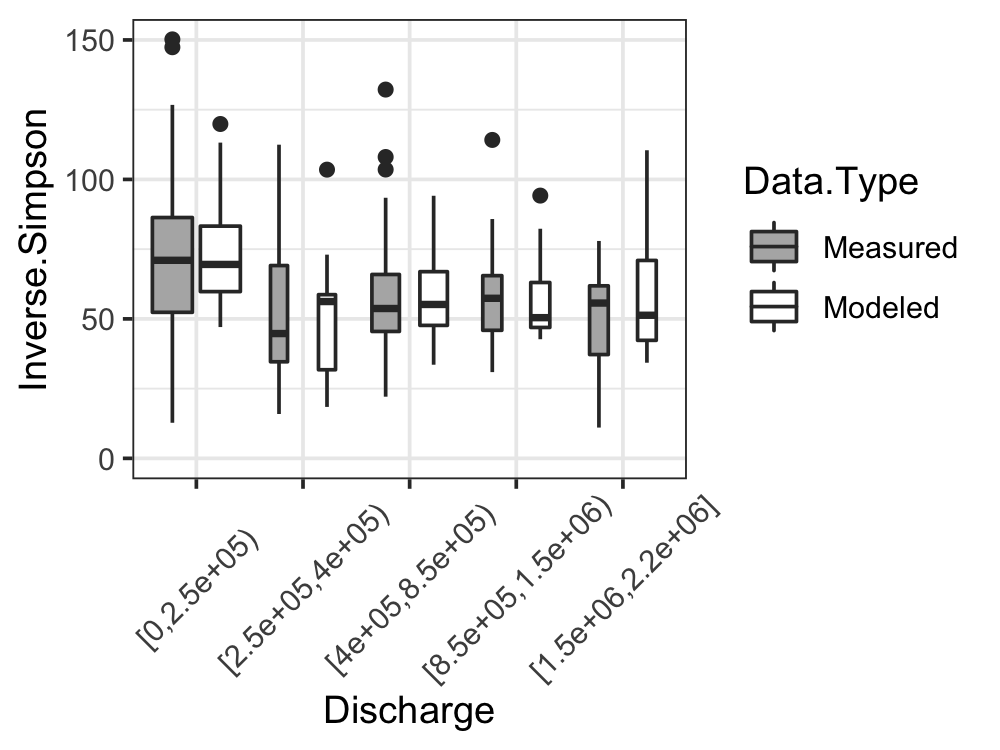

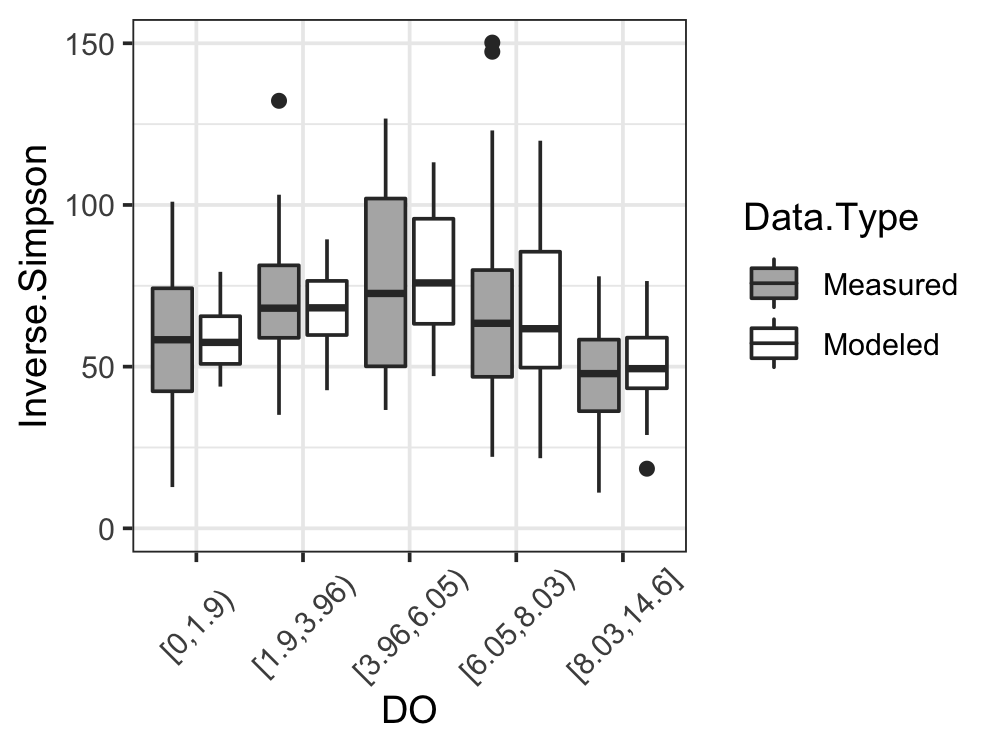

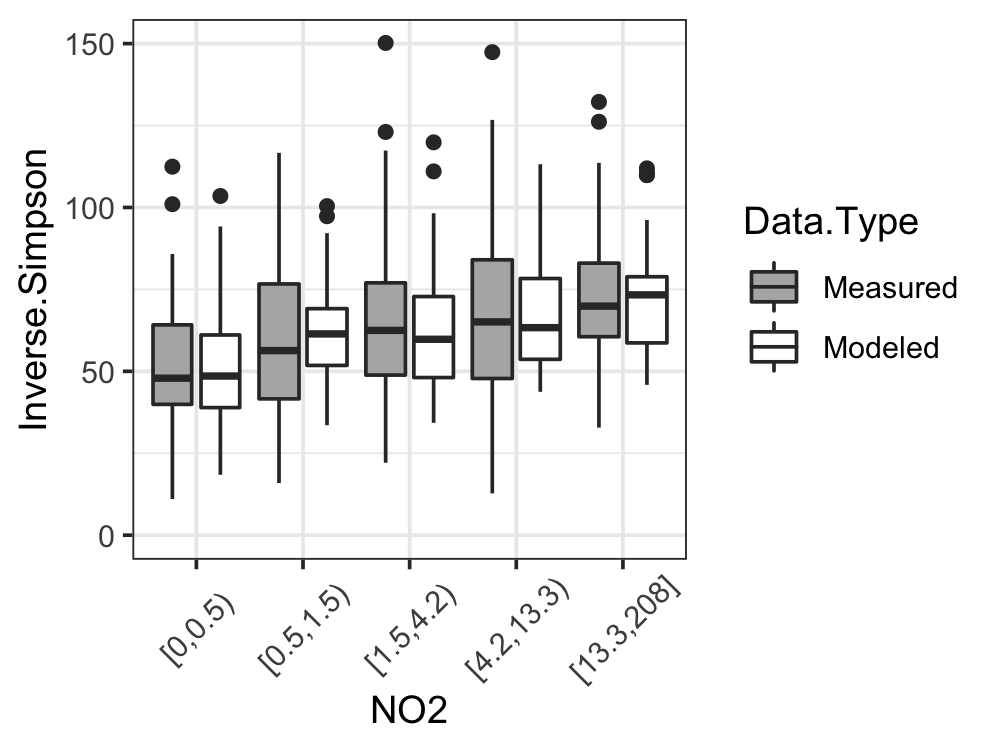

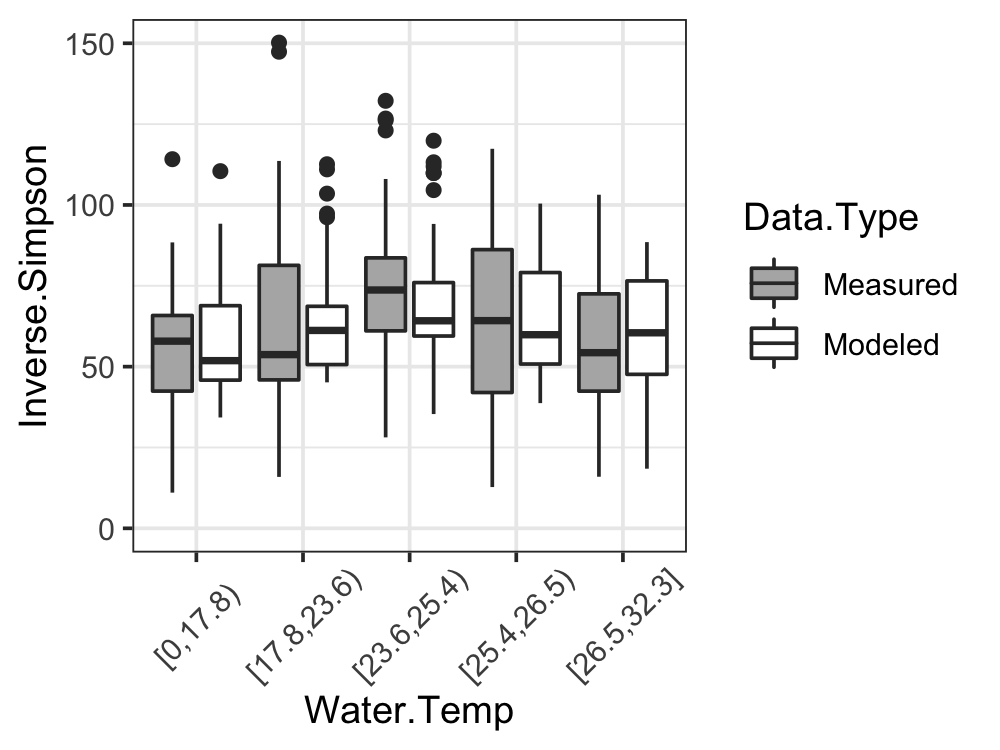

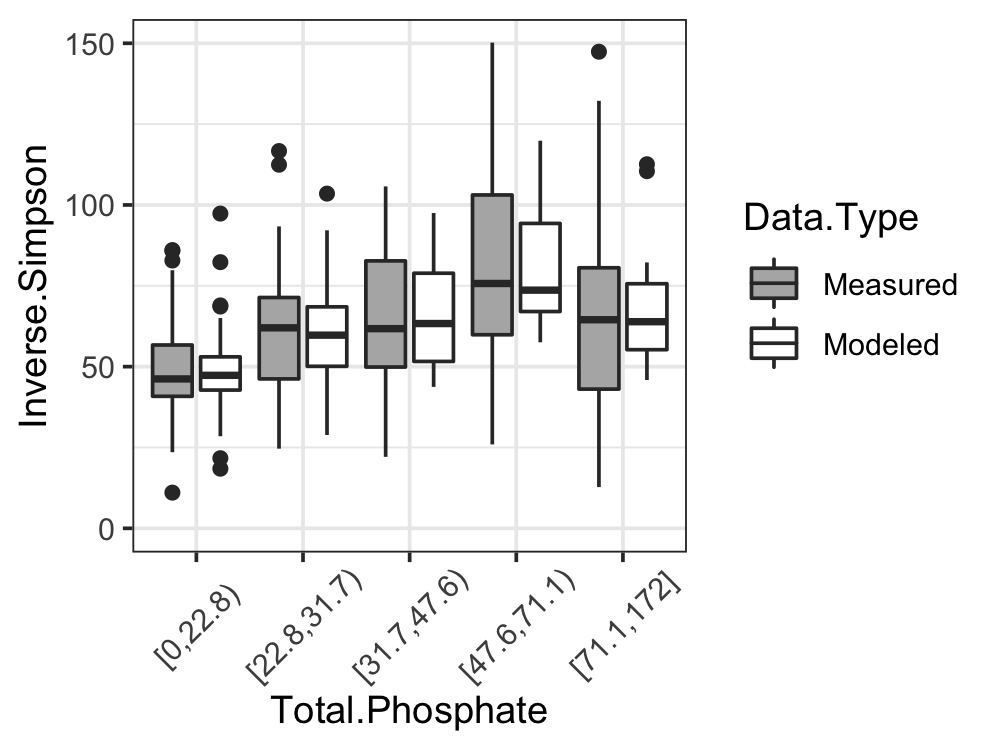

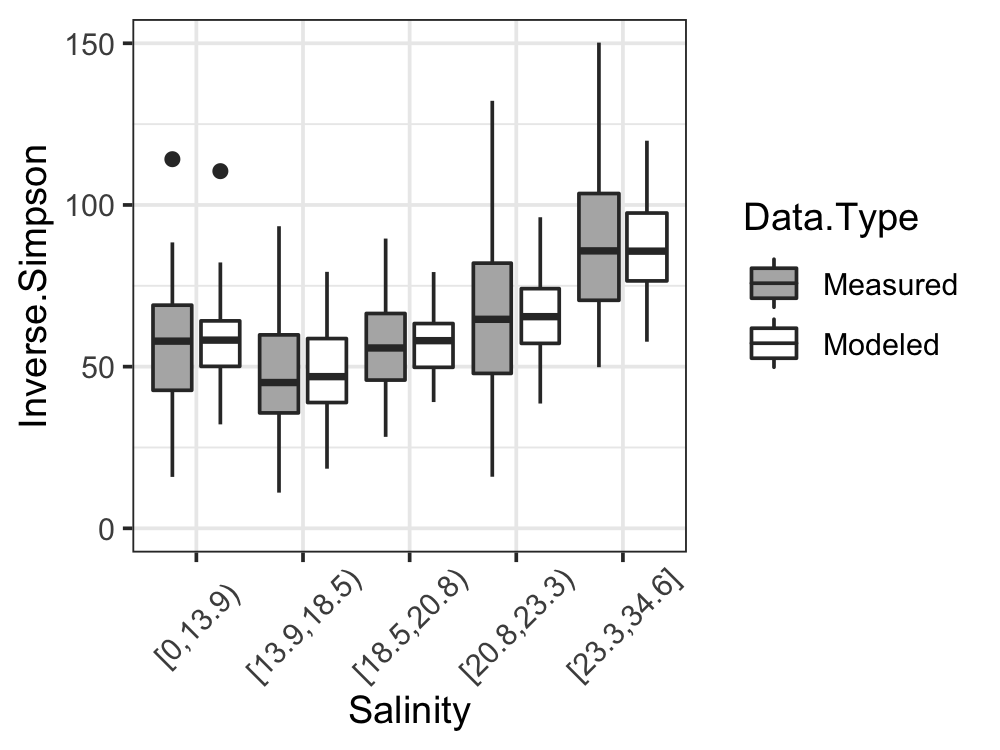

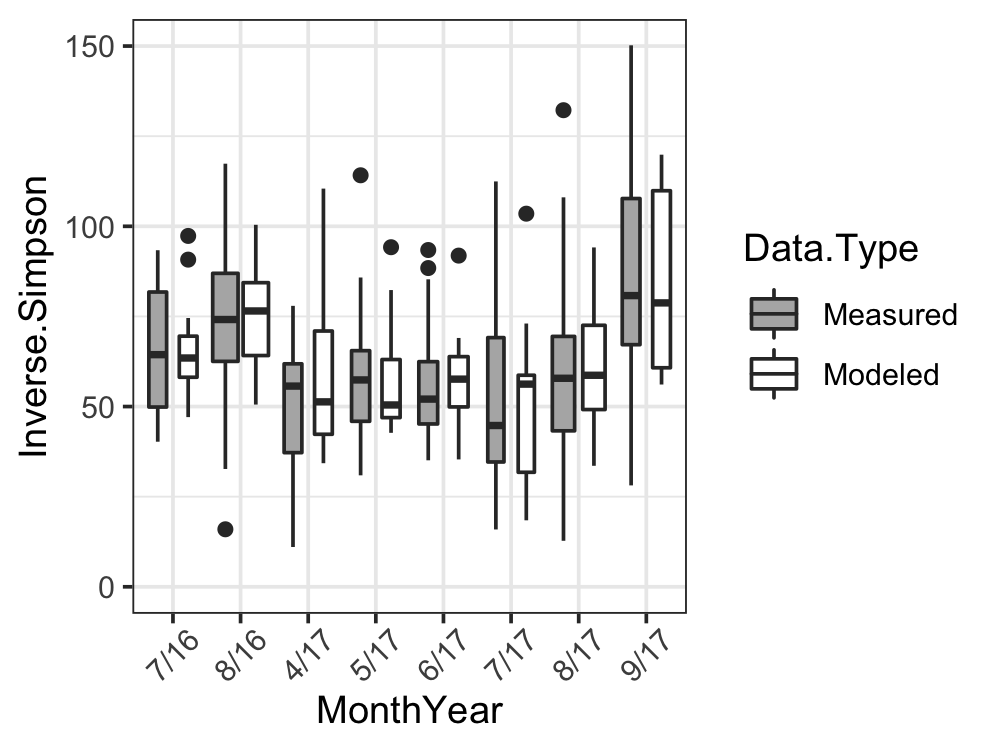

In [52]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 250)

bp <- ggplot(obsmod_df, aes(x=Discharge, y=Inverse.Simpson, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) + coord_cartesian(ylim=c(0, 150))

bp2 <- ggplot(obsmod_df, aes(x=NO2, y=Inverse.Simpson, fill=Data.Type)) + 
       geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) + coord_cartesian(ylim=c(0, 150))

bp3 <- ggplot(obsmod_df, aes(x=DO, y=Inverse.Simpson, fill=Data.Type)) + 
       geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) + coord_cartesian(ylim=c(0, 150))

bp4 <- ggplot(obsmod_df, aes(x=Total.Phosphate, y=Inverse.Simpson, fill=Data.Type)) + 
       geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) + coord_cartesian(ylim=c(0, 150))

bp1 <- ggplot(obsmod_df, aes(x=Water.Temp, y=Inverse.Simpson, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) + coord_cartesian(ylim=c(0, 150))

bp5 <- ggplot(obsmod_df, aes(x=Salinity, y=Inverse.Simpson, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) + coord_cartesian(ylim=c(0, 150))


bp6 <- ggplot(obsmod_df, aes(x=MonthYear, y=Inverse.Simpson, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) + coord_cartesian(ylim=c(0, 150))

bp
bp3
bp2
bp1
bp4
bp5
bp6

In [21]:
library(caret)
fM1 <- lm(FaithsPD ~ Discharge_Susquehanna.15 + WaterColumnPosition + TP, data = pred_resp_f)
fM2 <- lm(FaithsPD ~ Discharge_Susquehanna.15:WaterColumnPosition + TP, data = pred_resp_f)
fM3 <- lm(FaithsPD ~ Discharge_Susquehanna.15 + TP:WaterColumnPosition, data = pred_resp_f)
anova(fM1, fM2, fM3)
postResample(pred=predict(fM1), obs=pred_resp_f$FaithsPD)
postResample(pred=predict(fM2), obs=pred_resp_f$FaithsPD)
postResample(pred=predict(fM3), obs=pred_resp_f$FaithsPD)
#anova(fM3)
#summary(fM3)
#vif(fM3)
pred_resp_f2 = cbind.data.frame(pred_resp_f, envdata_pre[,'cruise_id'])
colnames(pred_resp_f2)[colnames(pred_resp_f2) == 'envdata_pre[, "cruise_id"]'] = 'cruise.id'
colnames(pred_resp_f2)


Attaching package: ‘caret’


The following object is masked from ‘package:vegan’:

    tolerance




,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,232,0.1880504,NA,NA,NA,NA
2,232,0.2042681,0,-0.016217628,NA,NA
3,232,0.1970880,0,0.007180076,NA,NA


RMSE   Rsquared        MAE 
0.02822807 0.49429805 0.02049291

RMSE   Rsquared        MAE 
0.02942011 0.45068588 0.02183394

RMSE   Rsquared        MAE 
0.02889842 0.46999442 0.02130089

[1] "PHEO"                     "TN"                      
 [3] "TP"                       "CHLA"                    
 [5] "DOP"                      "DON"                     
 [7] "NH4F"                     "NO2F"                    
 [9] "NO3F"                     "PC"                      
[11] "PO4F"                     "DO"                      
[13] "PH"                       "SALINITY"                
[15] "WTEMP"                    "Latitude"                
[17] "Habitat"                  "StatName"                
[19] "WaterColumnPosition"      "LinearTime"              
[21] "FallPeak"                 "Discharge_Susquehanna.15"
[23] "Discharge_Sum.15"         "DayLength"               
[25] "Microbial.Clusters"       "FaithsPD"                
[27] "cruise.id"

In [22]:
vf4 <- varIdent(form =~ StatName)
vf5 <- varIdent(form =~ WaterColumnPosition)
vf6 <- varExp(form =~ SALINITY)
vf7 <- varIdent(form =~ cruise.id)

fA2 <- gam(FaithsPD ~ s(FallPeak, bs='cs', k=8) + TP + WaterColumnPosition, data = pred_resp_f2)

fAM2 <- gamm(FaithsPD ~ s(FallPeak, bs='cs') + s(TP, bs='cs'),
                        data = pred_resp_f2, weights = vf4)

fAM3 <- gamm(FaithsPD ~ s(FallPeak, bs='cs') + s(TP, bs='cs'),
                        data = pred_resp_f2, weights = vf5)

fAM4 <- gamm(FaithsPD ~ FallPeak + s(TP) + WaterColumnPosition,
                        data = pred_resp_f2, weights=vf7)

postResample(pred=predict(fA2), obs=pred_resp_f$FaithsPD)
postResample(pred=predict(fAM2$gam), obs=pred_resp_f$FaithsPD)
postResample(pred=predict(fAM3$gam), obs=pred_resp_f$FaithsPD)
postResample(pred=predict(fAM4$gam), obs=pred_resp_f$FaithsPD)

summary(fA2)
AIC(fA2)
summary(fAM4$gam)
AIC(fAM4$lme)
anova(fA2)
coef(fA2)

RMSE   Rsquared        MAE 
0.02824876 0.49358326 0.02028959

RMSE   Rsquared        MAE 
0.03000962 0.42863658 0.02213892

RMSE   Rsquared        MAE 
0.03000962 0.42863658 0.02213892

RMSE   Rsquared        MAE 
0.02839710 0.48822341 0.02022076


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(FallPeak, bs = "cs", k = 8) + TP + WaterColumnPosition

Parametric coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.988813   0.002280 872.435  < 2e-16 ***
TP                        0.012392   0.002609   4.750 3.57e-06 ***
WaterColumnPositionupper -0.029599   0.005114  -5.788 2.31e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df     F  p-value    
s(FallPeak) 1.652      7 3.485 8.84e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.486   Deviance explained = 49.4%
GCV = 0.00083041  Scale est. = 0.00081404  n = 236

[1] -1002.442


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ FallPeak + s(TP) + WaterColumnPosition

Parametric coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.989046   0.002279 872.595  < 2e-16 ***
FallPeak                  0.010850   0.002237   4.851 2.25e-06 ***
WaterColumnPositionupper -0.030498   0.005096  -5.985 8.16e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
      edf Ref.df     F  p-value    
s(TP)   1      1 20.21 1.08e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.482   
  Scale est. = 0.0008064  n = 236

[1] -999.274


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(FallPeak, bs = "cs", k = 8) + TP + WaterColumnPosition

Parametric Terms:
                    df     F  p-value
TP                   1 22.56 3.57e-06
WaterColumnPosition  1 33.50 2.31e-08

Approximate significance of smooth terms:
              edf Ref.df     F  p-value
s(FallPeak) 1.652  7.000 3.485 8.84e-07

(Intercept)                       TP WaterColumnPositionupper 
            1.9888134572             0.0123918987            -0.0295993640 
           s(FallPeak).1            s(FallPeak).2            s(FallPeak).3 
           -0.0095122979             0.0002553616             0.0120924275 
           s(FallPeak).4            s(FallPeak).5            s(FallPeak).6 
            0.0131233792             0.0111227756             0.0166792846 
           s(FallPeak).7 
            0.0131697256

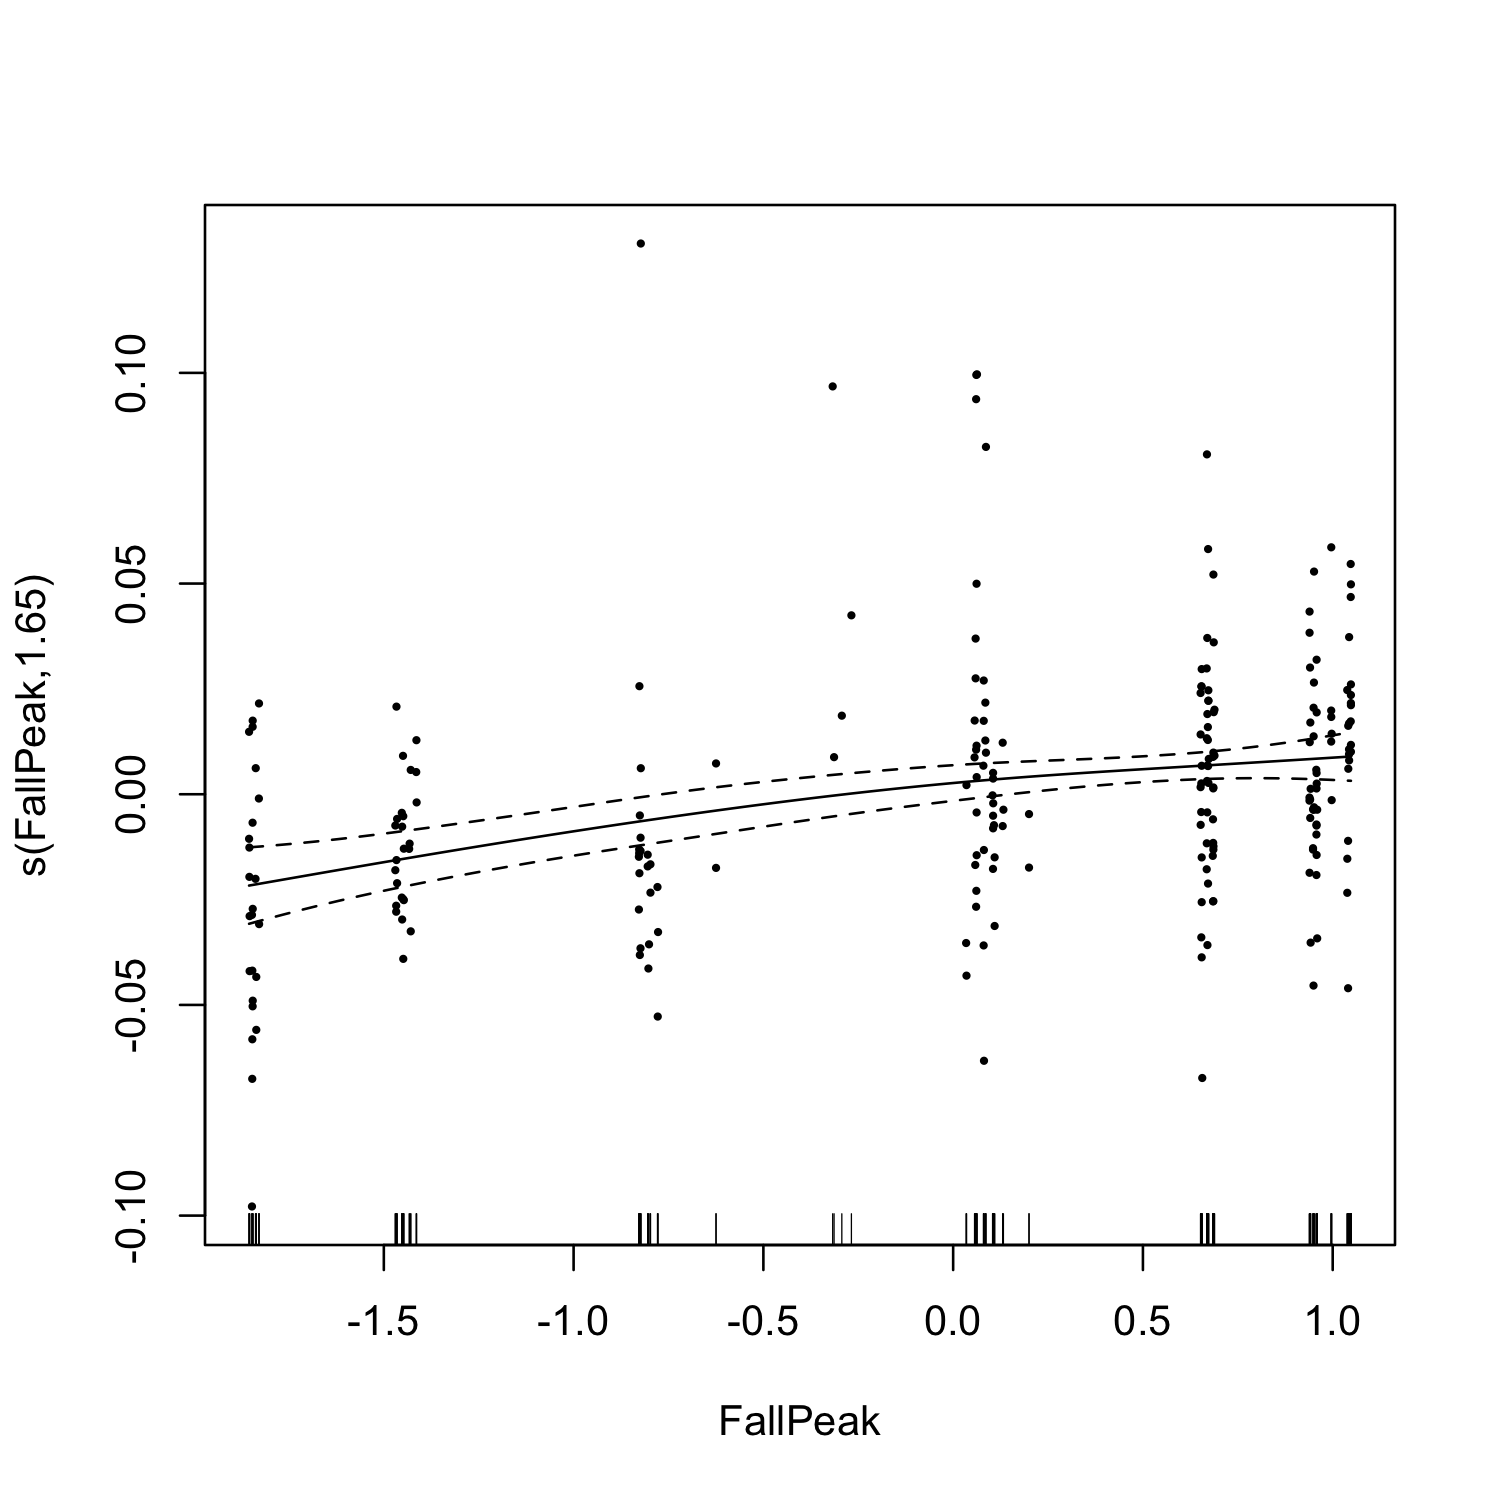

In [23]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 250)
#op <- par(mfrow = c(2, 2))
plot(fA2, residuals=TRUE, pch=19, cex=.3, scale=0)


	Anderson-Darling normality test

data:  fE2
A = 1.9104, p-value = 6.914e-05


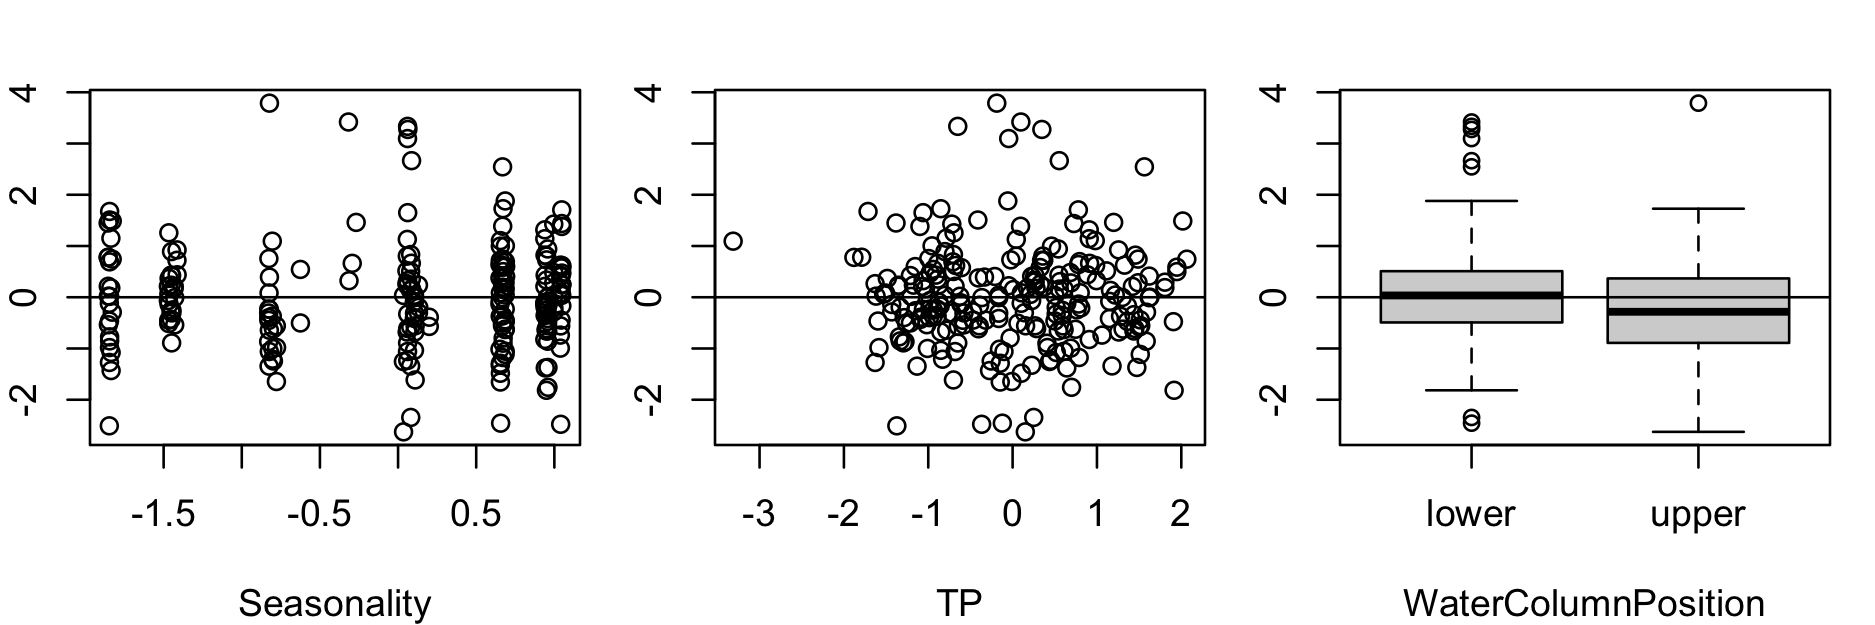

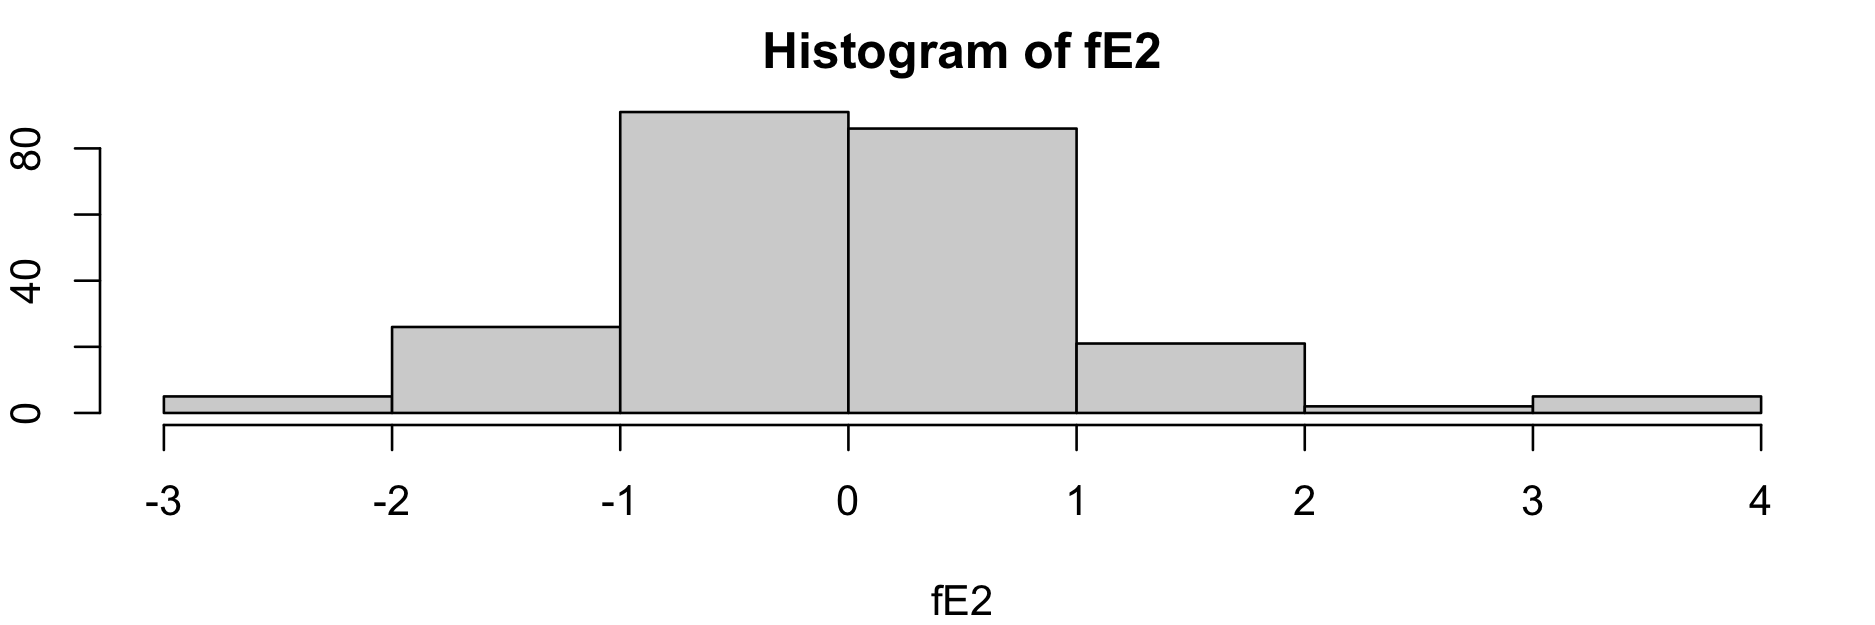

In [24]:
options(repr.plot.width=7.5, repr.plot.height=2.5)
par(mfrow = c(1, 3), mar=c(4,2,2,1), cex=0.9)
fE2 <- scale(resid(fM3))
Fit.fA2 <- fitted(fM3)
ad.test(fE2)
plot(y = fE2, x = pred_resp_f[,'FallPeak'], xlab = "Seasonality", ylab = "Residuals")
abline(0,0)
plot(fE2 ~ pred_resp_f[,'TP'], xlab = "TP", ylab = "Residuals")
abline(0, 0)
boxplot(fE2 ~ pred_resp_f[,'WaterColumnPosition'], xlab = "WaterColumnPosition", ylab = "Residuals")
abline(0, 0)
par(op)

hist(fE2)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 7 iterations.
The RMS GCV score gradient at convergence was 8.599881e-09 .
The Hessian was positive definite.
Model rank =  10 / 10 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

              k'  edf k-index p-value
s(FallPeak) 7.00 1.65    0.96    0.18


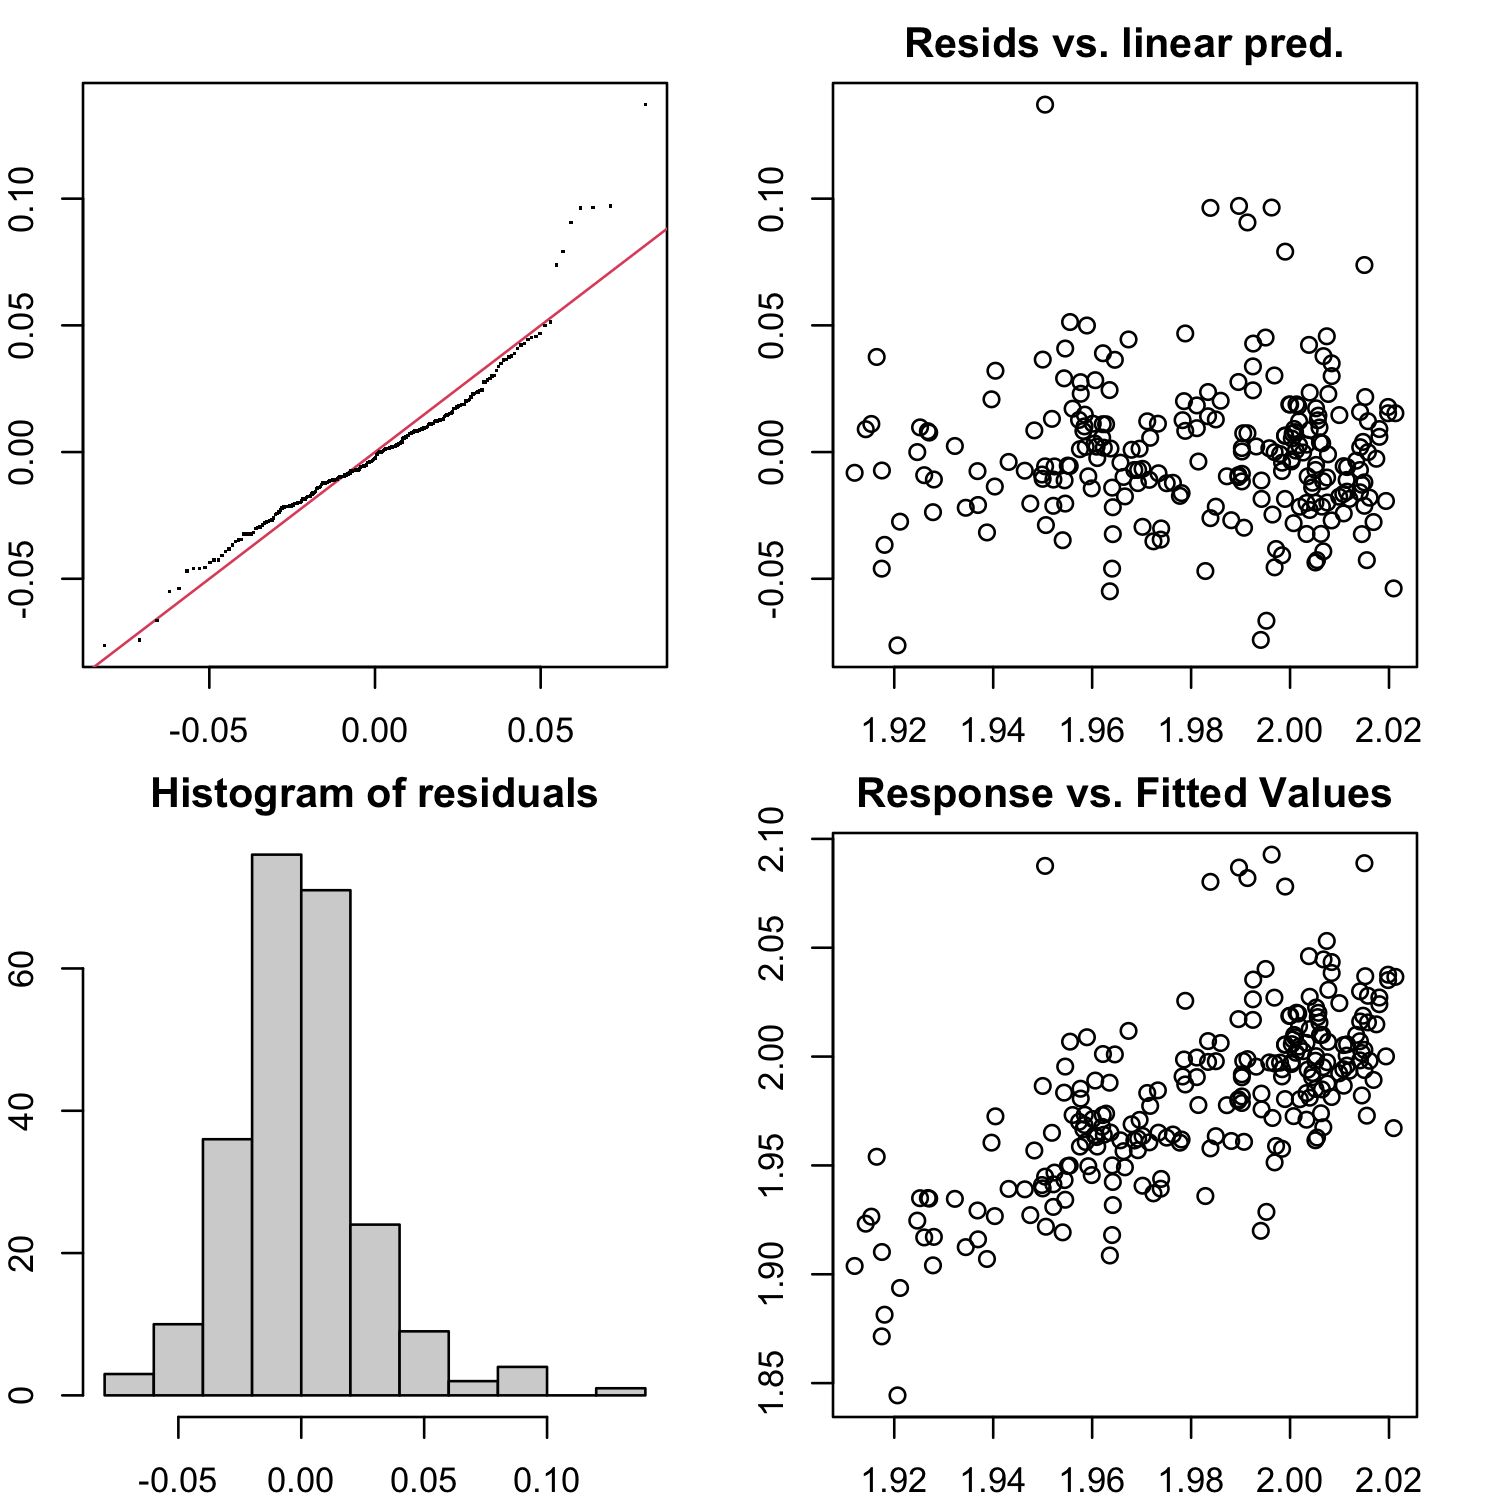

In [25]:
options(repr.plot.width=6, repr.plot.height=6)
par(mar = c(2, 2, 2, 2))
gam.check(fA2)


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(Water.Temp, bs = "cs", k = 8) + Total.Phosphate + 
    Surface.Bottom

Parametric coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.939e+00  4.181e-03 463.625  < 2e-16 ***
Total.Phosphate      3.391e-04  7.229e-05   4.691 4.73e-06 ***
Surface.BottomBottom 3.497e-02  4.782e-03   7.313 4.60e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                edf Ref.df     F  p-value    
s(Water.Temp) 3.994      7 7.929 2.47e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.497   Deviance explained =   51%
GCV = 0.00081867  Scale est. = 0.00079388  n = 231

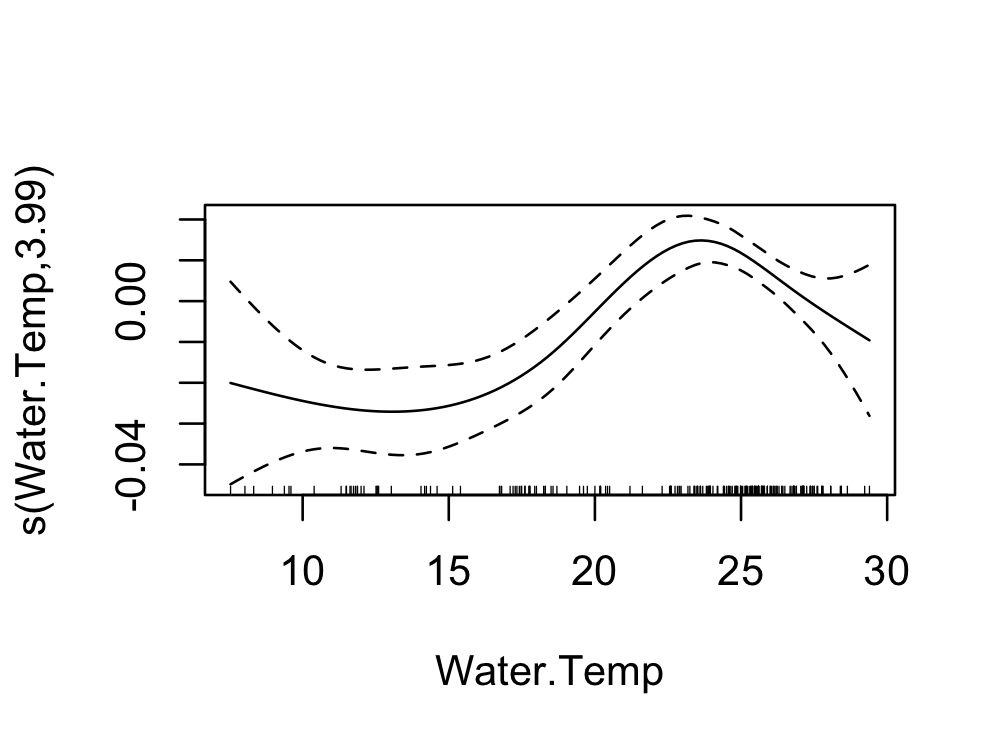

In [35]:
library(lubridate)
selected_predictors1 = c('WTEMP', 'cruise_id', 'TP', 'FallPeak', 'SampleDate', 'WaterColumnPosition', 'LinearTime', 'SALINITY')
selected_predictors2 = c('StatName')
selected_response = c('FaithsPD')
obs_df = cbind.data.frame(envdata_pre[,selected_predictors1], envdata[,selected_predictors2], 
                          pred_resp_f[,selected_response])
obs_df = obs_df[complete.cases(obs_df),]
colnames(obs_df) <- c(selected_predictors1, selected_predictors2, selected_response)

obs_df[,'MonthYear'] <- paste(month(as.POSIXlt(obs_df$SampleDate)), "/", substring(year(as.POSIXlt(obs_df$SampleDate)), 3), sep="")
obs_df[,'MonthYear'] <- factor(obs_df[,'MonthYear'], 
                               levels=c('7/16', '8/16', '4/17', '5/17', '6/17', '7/17', '8/17', '9/17'))
obs_df[,'Month'] <- factor(month(as.POSIXlt(obs_df$SampleDate)))
colnames(obs_df)[colnames(obs_df) == 'cruise_id'] = 'Cruise.ID'
obs_df$Cruise.ID <- factor(obs_df$Cruise.ID)
colnames(obs_df)[colnames(obs_df) == 'MonthYear'] = 'Month.Year'
obs_df$TP = obs_df$TP*1000
colnames(obs_df)[colnames(obs_df) == 'TP'] = 'Total.Phosphate'
colnames(obs_df)[colnames(obs_df) == 'WaterColumnPosition'] = 'Surface.Bottom'
colnames(obs_df)[colnames(obs_df) == 'FallPeak'] = 'Seasonality.Fxn'
colnames(obs_df)[colnames(obs_df) == 'StatName'] = 'Station.Group'
colnames(obs_df)[colnames(obs_df) == 'SALINITY'] = 'Salinity'
colnames(obs_df)[colnames(obs_df) == 'WTEMP'] = 'Water.Temp'

obs_df[which(obs_df$Surface.Bottom == 'upper'), 'Surface.Bottom'] = 'Surface'
obs_df[which(obs_df$Surface.Bottom == 'lower'), 'Surface.Bottom'] = 'Bottom'

obs_df$Surface.Bottom = factor(obs_df$Surface.Bottom, levels=c('Surface', 'Bottom'))

obs_df[,'Data.Type'] = 'Measured'
mod_df = obs_df
mod_df[,'Data.Type'] = 'Modeled'
fM3 <- gam(FaithsPD ~ s(Water.Temp, bs='cs', k=8) + Total.Phosphate + Surface.Bottom, data = obs_df)
summary(fM3)
plot(fM3, scale=0)


In [36]:
mod_df[,'FaithsPD'] <- predict(fM3)[rownames(obs_df)]
obsmod_df = rbind.data.frame(obs_df, mod_df)
obsmod_df$FaithsPD = ((obsmod_df$FaithsPD*xform_const) + 1)^(1/xform_const)
obsmod_df$Data.Type <- as.character(obsmod_df$Data.Type)

obsmod_df$ADLF <- NA
obsmod_df[, 'ADLF'] = cut(obsmod_df$Water.Temp, breaks=c(0, quantile(obsmod_df$Water.Temp, c(0.2,0.4,0.6,0.8)), 
                                                              max(obsmod_df$Water.Temp)*1.1), include.lowest = T, right = F)
obsmod_df$Water.Temp = obsmod_df$ADLF
table(obsmod_df$ADLF)

obsmod_df[, 'TPFactor'] <-NA
obsmod_df[, 'TPFactor'] = cut(obsmod_df$Total.Phosphate, breaks=c(0, quantile(obsmod_df$Total.Phosphate, c(0.2,0.4,0.6,0.8)), 
                                               max(obsmod_df$Total.Phosphate)*1.1), include.lowest = T, right = F)
obsmod_df$Total.Phosphate = obsmod_df$TPFactor
table(obsmod_df$TPFactor)

obsmod_df[, 'SALFactor'] <-NA
obsmod_df[, 'SALFactor'] = cut(obsmod_df$Salinity, breaks=c(0, quantile(obsmod_df$Salinity, c(0.2,0.4,0.6,0.8)), 
                                               max(obsmod_df$Salinity)*1.1), include.lowest = T, right = F)
obsmod_df$Salinity = obsmod_df$SALFactor
table(obsmod_df$SALFactor)

colSums(is.na(obsmod_df))


   [0,17.8) [17.8,23.6) [23.6,25.4) [25.4,26.5) [26.5,32.3] 
         92          92          92          92          94 


   [0,22.8) [22.8,31.7) [31.7,47.6) [47.6,71.1)  [71.1,172] 
         92          92          92          92          94 


   [0,13.9) [13.9,18.5) [18.5,20.8) [20.8,23.3) [23.3,34.6] 
         92          92          92          88          98 

Water.Temp       Cruise.ID Total.Phosphate Seasonality.Fxn      SampleDate 
              0               0               0               0               0 
 Surface.Bottom      LinearTime        Salinity   Station.Group        FaithsPD 
              0               0               0               0               0 
     Month.Year           Month       Data.Type            ADLF        TPFactor 
              0               0               0               0               0 
      SALFactor 
              0

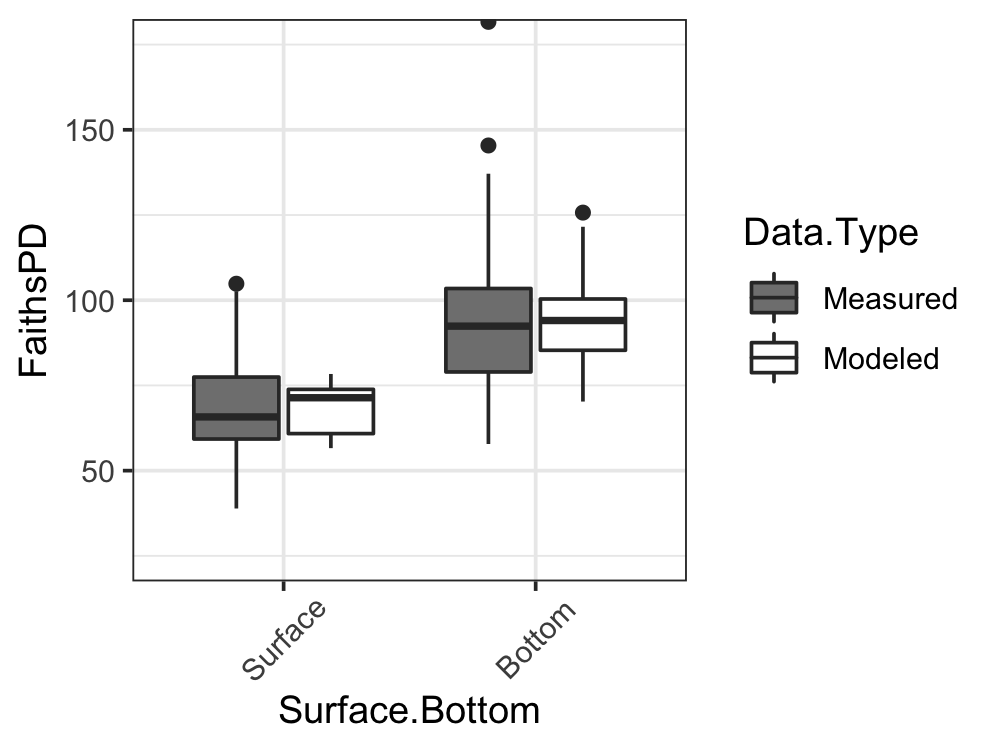

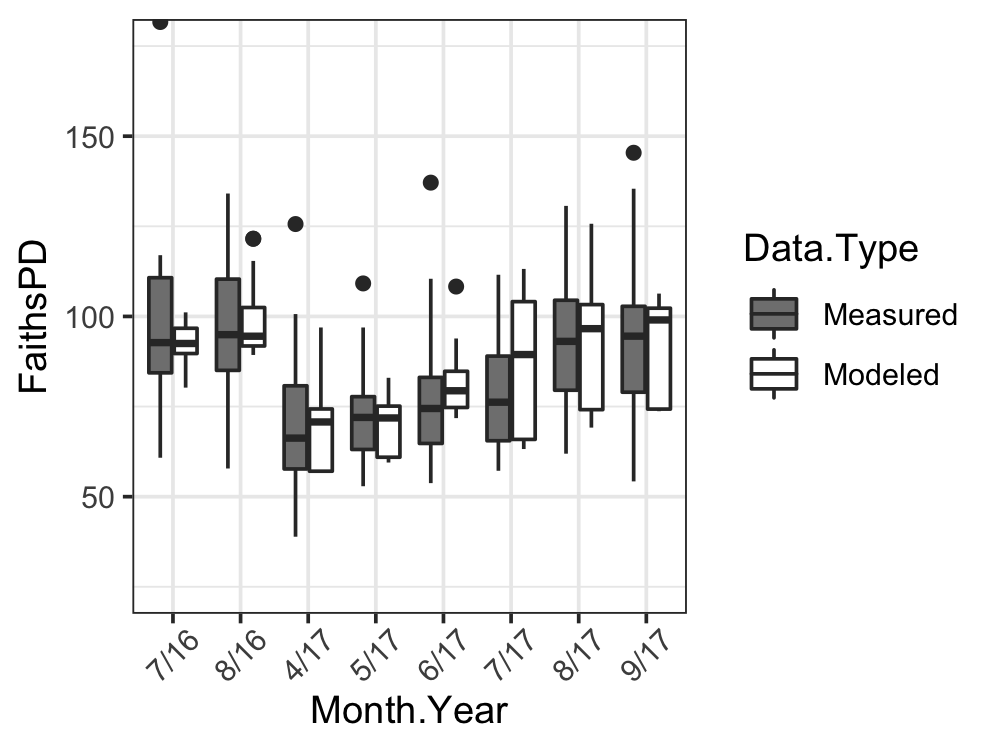

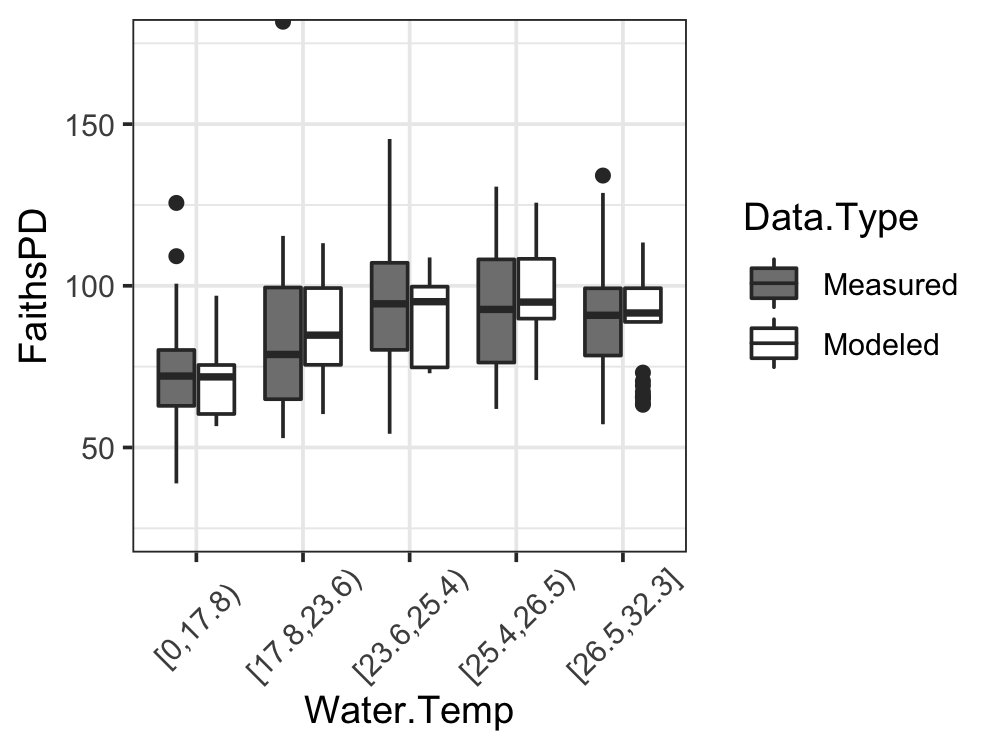

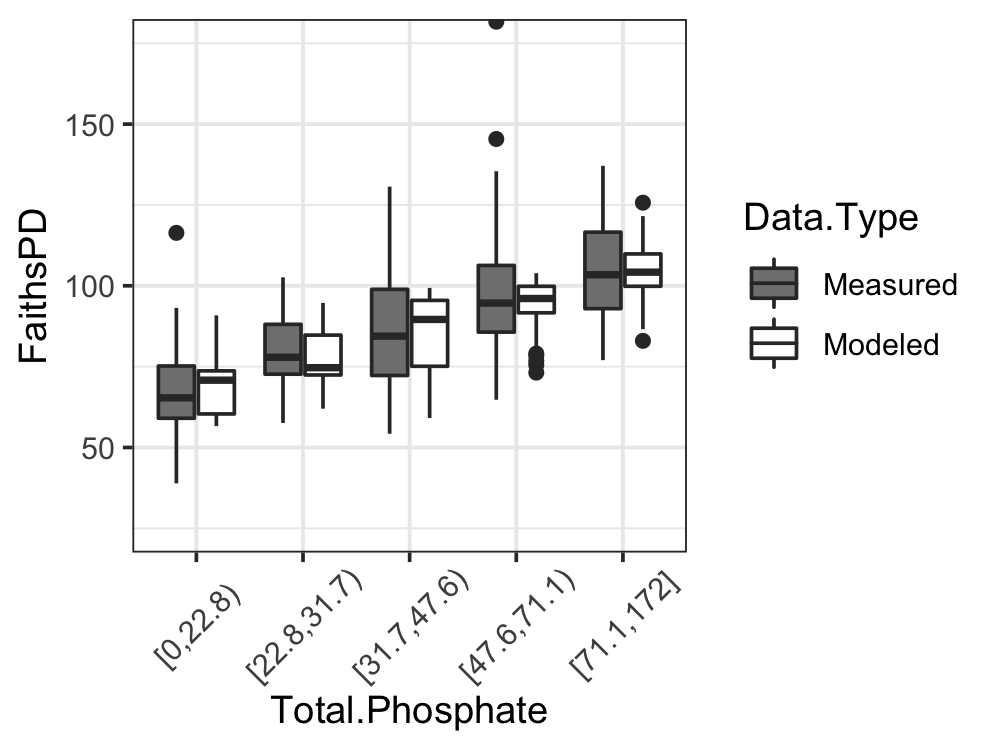

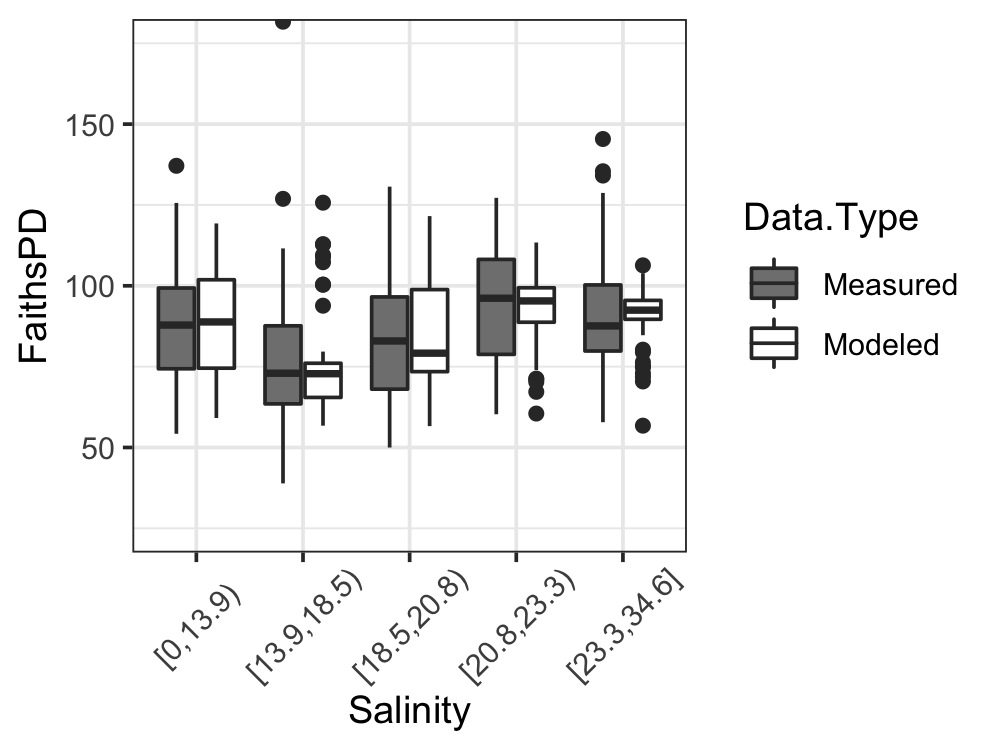

In [39]:
options(repr.plot.width=4, repr.plot.height=3)
bp <- ggplot(obsmod_df, aes(x=Surface.Bottom, y=FaithsPD, fill=Data.Type)) + 
      geom_boxplot() + scale_fill_grey(start=0.5, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))+ coord_cartesian(ylim=c(25, 175))

bp2 <- ggplot(obsmod_df, aes(x=Water.Temp, y=FaithsPD, fill=Data.Type)) + 
       geom_boxplot() + scale_fill_grey(start=0.5, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))+ coord_cartesian(ylim=c(25, 175))

bp_B <- ggplot(obsmod_df, aes(x=Month.Year, y=FaithsPD, fill=Data.Type)) + 
      geom_boxplot() + scale_fill_grey(start=0.5, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))+ coord_cartesian(ylim=c(25, 175))

bp2_B <- ggplot(obsmod_df, aes(x=Total.Phosphate, y=FaithsPD, fill=Data.Type)) + 
       geom_boxplot() + scale_fill_grey(start=0.5, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) + coord_cartesian(ylim=c(25, 175))

bp3 <- ggplot(obsmod_df, aes(x=Salinity, y=FaithsPD, fill=Data.Type)) + 
        geom_boxplot() + scale_fill_grey(start=0.5, end=1.0) + 
        theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) + coord_cartesian(ylim=c(25, 175))


bp
bp_B
bp2
bp2_B
bp3



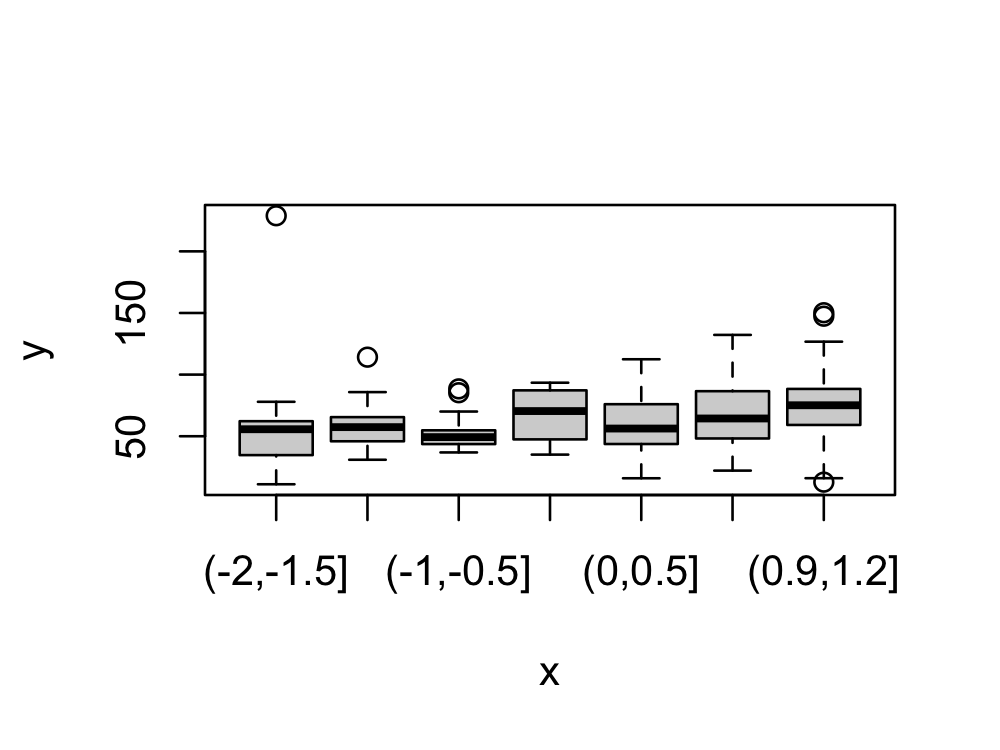

In [47]:
plot(cut(predictors_$FallPeak, c(-2., -1.5, -1, -0.5, 0, 0.5, .9, 1.2)), response_2)

In [ ]:

library(mgcv)
mixing_f = "/Volumes/KeithSSD/CB_V4/otu_data/mixing_data/2016_transect_mixing_data_products.txt"
mix_df = read.delim(mixing_f, row.names=2)
mix_df$X <- NULL
select_cols = c('faith_pd', 'WTEMP', 'Latitude', 'Depth', 'StatName', 'DO', 'PH',
                'SALINITY', 'anti_day_length', 'AC_PrinComp2', 'julian_day')

subfull = fulldata[rownames(mix_df), select_cols]
mixing_plus = cbind.data.frame(subfull, mix_df[,c(6:ncol(mix_df))])

# standardize the numeric columns
predictors_ns <- mixing_plus %>% mutate_if(is.numeric, list(~ as.numeric(scale(.))) )

corr <- data.frame(lapply(predictors_ns[,c('faith_pd', 'Latitude', 'DO','south_lim', 'WTEMP')], as.double))
# Plot the graph
#options(repr.plot.width=7, repr.plot.height=7)
#ggcorr(corr, method = c("pairwise", "spearman"), nbreaks = 6,
#       hjust = 0.92, size=4, label = TRUE, label_size = 2, color = "grey25")

pred_cols = c('WTEMP', 'Latitude', 'Depth', 'StatName', 'DO', 'PH', 'SALINITY', 
              'anti_day_length', 'AC_PrinComp2', 'julian_day', 'sum_horiz_dist', 'sum_vert_dist',
              'sum_downwelling', 'sum_upwelling', 'north_lim', 'south_lim', 'east_lim', 'west_lim',
              'up_lim', 'down_lim')
sum(pred_cols %in% colnames(mixing_plus))
length(pred_cols)
stepper = gam(faith_pd ~ s(Latitude, br='cs') + s(Depth, br='cs') + s(DO, br='cs') + s(PH, br='cs') + s(SALINITY, br='cs') + s(anti_day_length, br='cs') + s(AC_PrinComp2, br='cs') + s(julian_day, br='cs') + s(sum_horiz_dist, br='cs') + s(sum_vert_dist, br='cs') + s(sum_downwelling, br='cs') + s(sum_upwelling, br='cs') + s(north_lim, br='cs') + s(south_lim, br='cs') + s(east_lim, br='cs') + s(west_lim, br='cs') + s(up_lim, br='cs') + s(down_lim, br='cs'), data=mixing_plus)
#stepper
#fbstep_enspie = stepAIC(lower_model, scope=formula(upper_model), scale = 0, direction = 'forward', k=log(n), trace=0)
#length(colnames(fbstep_enspie$model))


fM2 <- gam(faith_pd ~ s(DO, bs = "cs") + s(south_lim, bs='cs') + s(WTEMP, bs='cs'), data = mixing_plus)


#anova(fM2)
#anova(fM2)
#summary(fM2)
#shapiro.test(resid(fM2))


In [ ]:
paste(colnames(mixing_plus), collapse="','")

In [ ]:
lmc <- lmeControl(niterEM = 5200, msMaxIter = 5200)

Mlm <- lm(Faiths.PD ~ Month*Year + Depth, data=faiths_df)
Mlme1 <- lme(Faiths.PD ~ 1 + Month + Depth, random = ~ 1 | Year, data=faiths_df, method="ML")
Mlme2 <- lme(Faiths.PD ~ 1 + Year + Depth, random = ~ 1 | Month, data=faiths_df, method="ML")

AIC(Mlme1, Mlme2, Mlm)
anova(Mlme1, Mlme2, Mlm)
summary(Mlme1)

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
E2 <- resid(Mlme1, type = "normalized")
F2 <- fitted(Mlme1)
op <- par(mfrow = c(2, 2), mar = c(4, 4, 3, 2))
MyYlab <- "Residuals"
plot(x = F2, y = E2, xlab = "Fitted values", ylab = MyYlab)
boxplot(E2 ~ faiths_df$Year, main = "Year", ylab = MyYlab)
plot(E2 ~ faiths_df$Depth, main = "Depth", ylab = MyYlab)
plot(x = month_year2, y = E2, ylab = MyYlab, main = "Month Year")
par(op)

In [ ]:



# cross validating smoothers is given by: 
# AM2 <- gam(ABUND  ̃ s(L.AREA, bs = "cs") + s(L.DIST, bs = "cs") + s(L.LDIST,bs = "cs") 
#                  + s(YR.ISOL, bs = "cs") + s(ALT, bs = "cs") + fGRAZE, data = Loyn)
# "edf" column in summary will show the relative amount of smoothing, if = 0, term is linear? 
# plots residuals against fitted values
# > plot(M1, which = c(1), col = 1, add.smooth = FALSE, caption = "")
# plot the residuals against each individual explanatory variable
# > plot(Squid$fMONTH, resid(M1), xlab = "Month", ylab = "Residuals")
# > plot(Squid$DML, resid(M1), xlab = "DML", ylab = "Residuals")
## This plots the residuals versus the two predictors in question, there is a facet for each factor level in month
# > E <- resid(M.lm)
# > coplot(E ∼ DML | fMONTH, data = Squid)


# (generalized least squares is a flavor of linear model with homogeneity corrections) 
# when the residuals deviate systematically with a variable, you can use a fixed variance structure:
# M.gls1 <- gls(Testisweight ∼ DML * fMONTH, weights = varFixed(∼DML), data = Squid)
# compare with: 
# M.lm <- gls(Testisweight ∼ DML * fMONTH, data=Squid)
# AIC(M.lm, M.gls1)
# if there is a variance structure that changes per a factor explanatory variable, we use:
# vf2 <- varIdent(form= ∼ 1 | fMONTH)
# as an alternative for the previous two, we can try:
# vf4 <- varPower(form =∼ DML | fMONTH) OR varExp(form =∼ DML | fMONTH) OR varConstPower(form =∼ DML | fMONTH)
# it is not clear if we can combine terms in varFixed or varIdent, but we can combine them seperately, e.g.
# vf8 <- varComb(varIdent(form =∼ 1 | fMONTH) , varExp(form =∼ DML) )
# varPower cannot be used if the covariate is ever equal to 0
## To confirm your choice, plot the error distribution versus predictors 
#E2 <- resid(M.gls4, type = "normalized") > coplot(E2 ∼ DML | fMONTH, data = Squid,
#ylab = "Normalised residuals")

#summary(continuous)
# plot a variable
#library(ggplot2)
#ggplot(continuous, aes(x = hours.per.week)) + geom_density(alpha = .2, fill = "#FF6666")
#ggplot(continuous, aes(x = educational.num)) + geom_density(alpha = .2, fill = "#32CD32")
#library(dplyr)

In [ ]:
set.seed(14)
create_train_test <- function(data, size = 0.8, train = TRUE) {
    n_row = nrow(data)
    total_row = size * n_row
    train_sample <- 1: total_row
    if (train == TRUE) {
        return (data[train_sample, ])
    } else {
        return (data[-train_sample, ])
    }
}
full_data = cbind(scale(response), predictors_ns)
colnames(full_data)[1] <- phenotype
row.names(full_data) <- row.names(mdata)
data_train <- create_train_test(full_data, 0.6, train = TRUE)
data_test <- create_train_test(full_data, 0.6, train = FALSE)
dim(data_train)
dim(data_test)
row.names(data_train)[1:5]

In [ ]:
head(data_train)

In [ ]:
library(scorer)
library(MASS)
library(caret)
library(leaps)
simple_model <- lm(faith_pd ~., data = data_train)
step_model <- stepAIC(simple_model, direction = "both", trace=FALSE)
ls(step_model)
summary(step_model)


In [ ]:
opt_model = lm(formula = faith_pd ~ Longitude + TrimCount + Year + julian_day + day_length + WTEMP + DO + PH + Depth_Percentage + Discharge_Susquehanna_14, data = data_train)
pred.w.clim <- predict(opt_model, data_test, interval = "confidence")
print(r2_score(data_test[,'faith_pd'], pred.w.clim[,'fit']))
pred.w.clim <- predict(simple_model, data_test, interval = "confidence")
print(r2_score(data_test[,'faith_pd'], pred.w.clim[,'fit']))



train.control <- trainControl(method="cv", number = 10)
step_model <- train(faith_pd ~., data = full_data, method = "leapSeq", trControl=train.control,
                    tuneGrid=data.frame(nvmax=1:15))

step_model$results
summary(step_model$finalModel)


In [ ]:
qqPlot(simple_model, simulate=T)
outlierTest(simple_model, labels=row.names(data_train))

In [ ]:
library(car)
pt_obj = powerTransform(continuous)
coef(p1, round=TRUE)
summary(m1 <- lm(bcPower(cycles, p1$roundlam) ~ len + amp + load, Wool))

#summary(p1 <- powerTransform(cycles ~ len + amp + load, Wool))
#ggplot(continuous, aes(x = hours.per.week)) + geom_density(alpha = .2, fill = "#FF6666")
#ggplot(data_adult_rescale, aes(x = educational.num)) + geom_density(alpha = .2, fill = "#32CD32")

In [ ]:
library(SoDA)
library(adespatial)
subm_geop <- mdata[,c("Longitude", "Latitude", "StationName")]
aggSub <- aggregate(.~ StationName, subm_geop, FUN=mean)

cart_coords = geoXY(latitude=aggSub$Latitude, longitude=aggSub$Longitude, unit=1000)
row.names(cart_coords) <- aggSub$StationName
stat_dists <- matrix(nrow=20, ncol=20)
for(i in 1:dim(stat_dists)[1]){
    for(j in 1:dim(stat_dists)[2]){
        stat_dists[i, j] <- geoDist(aggSub$Latitude[i], aggSub$Longitude[i], aggSub$Latitude[j], aggSub$Longitude[j])
    }
}
colnames(stat_dists) <- aggSub$StationName; row.names(stat_dists) <- aggSub$StationName;
cb.dbmem <- as.data.frame(dbmem(cart_coords, thresh = 45.0 ,silent = TRUE))
row.names(cb.dbmem) <- aggSub$StationName;
dim(mdata)
mdata[, colnames(cb.dbmem)] <- NA
for(cn in colnames(cb.dbmem)){
    for(stat_name in row.names(cb.dbmem)){
        mdata[mdata$StationName == stat_name , cn] <- cb.dbmem[stat_name, cn]
    }
}
head(mdata[c(66,77,99,111,155,200,225,250,300), colnames(cb.dbmem)])